## Initial attempts

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.typing import NDArray

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [1e6/(gammab*np.sqrt(3)) * x for x in [1, 1, 1]]
RABI_TIMES = np.linspace(0, 1e-7, 301)
RAMSEY_TIMES = np.linspace(0, 1e-5, 301)
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0*np.pi / 3
MW_PULSE_LENGTH_S = 2* np.linspace(0, 0.1e-6, 101) #[1e-6 * x for x in [0.01, 0.02]]
EVOLUTION_TIME_S = 4 *np.linspace(0, 5e-6, 201) #[1e-6 * x for x in [0,.1]]
T2STAR_S = 1e16

In [ ]:
nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_nv_single_species(NVOrientation.A, NV14HyperfineField.N14_0)
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(SECOND_PULSE_PHASE)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

#plt.plot(MW_PULSE_LENGTH_S,off_axis_simulation.ms0_results[:,0])
plt.imshow(off_axis_simulation.ms0_results)
plt.show()

In [ ]:

def imshow_with_extents(xaxis, yaxis, data: NDArray, aspect_ratio:float =1, vmin=None, vmax=None):
    if data.shape != (len(yaxis),len(xaxis)):
        raise ValueError("x-axis, y-axis shape doesn't match data")
    if len(xaxis) <= 1 or len(yaxis) <= 1:
        raise ValueError("x-axis, y-axis must have more than one data point")
    xstep = xaxis[1]-xaxis[0]
    ystep = yaxis[1]-yaxis[0]
    extents = [min(xaxis)-xstep/2, max(xaxis)+xstep/2, min(yaxis)-ystep/2, max(yaxis)+ystep/2,]
    intrinsic_aspect_ratio = (max(yaxis)-min(yaxis) + ystep)/(max(xaxis)-min(xaxis)+xstep)
    return plt.imshow(data, extent=extents, aspect=aspect_ratio/intrinsic_aspect_ratio, vmin=vmin, vmax=vmax)

In [ ]:
imshow_with_extents( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, off_axis_simulation.ms0_results)
plt.show()

In [ ]:
data=off_axis_simulation.ms0_results
ft = np.fft.fft2(data)
ft = np.fft.fftshift(ft)
rabifreqs=sorted(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = sorted(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
#plt.imshow(abs(ft), vmax=500)
plt.imshow(abs(ft), vmax=500, extent=[min(ramseyfreqs), max(ramseyfreqs),min(rabifreqs), max(rabifreqs)], aspect=.01)
plt.show()

In [ ]:
imshow_with_extents(ramseyfreqs,rabifreqs, abs(ft), vmax=500)
plt.show()

In [ ]:
rabifreqs = np.array(rabifreqs)
ramseyfreqs = np.array(ramseyfreqs)
maxrabi = 150e6
maxramsey = 3e6
rabi_mask = abs(np.array(rabifreqs))< maxrabi
ramsey_mask =  abs(np.array(ramseyfreqs))< maxramsey
data_mask=np.outer(rabi_mask, ramsey_mask)


In [ ]:
print(rabifreqs[rabi_mask].shape)
print(ramseyfreqs[ramsey_mask].shape)
print(data_mask.shape)
print(ft.shape)

In [ ]:
(ft[rabi_mask,:][:,ramsey_mask]).shape

In [ ]:
imshow_with_extents(ramseyfreqs[ramsey_mask],rabifreqs[rabi_mask], abs(ft[rabi_mask,:][:,ramsey_mask]), vmax=500)
plt.show()

In [ ]:
rabi_mask = np.all(np.array([(-maxrabi < rabifreqs), rabifreqs < maxrabi]), axis=0)
print(rabi_mask)
ramsey_mask =  abs(np.array(ramseyfreqs))< maxramsey
print(rabi_mask)

In [ ]:
def imshow_with_extents_and_crop(xaxis:NDArray, yaxis:NDArray, data: NDArray, aspect_ratio:float =1, xmin=None, xmax=None, ymin= None, ymax =None, vmin=None, vmax=None):
    small_quantity_to_ensure_no_cropping = 1
    if xmin==None:
        xmin = min(xaxis) - small_quantity_to_ensure_no_cropping
    if xmax==None:
        xmax = max(xaxis) + small_quantity_to_ensure_no_cropping
    if ymin==None:
        ymin = min(yaxis) - small_quantity_to_ensure_no_cropping
    if ymax==None:
        ymax = max(yaxis) + small_quantity_to_ensure_no_cropping
    x_mask = np.all(np.array([(xmin <= xaxis), xaxis <= xmax]), axis=0)
    y_mask = np.all(np.array([(ymin <= yaxis), yaxis <= ymax]), axis=0)
    print(x_mask)
    print(y_mask)
    imshow_with_extents(xaxis[x_mask], yaxis[y_mask],abs(data[y_mask,:][:,x_mask]), vmin=vmin, vmax=vmax, aspect_ratio=aspect_ratio)

In [ ]:
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(ft), ymin=0, vmax=500)
plt.show()

In [ ]:
np.linalg.norm(np.array([9e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]))

## Inversions

[0.57735027 0.57735027 0.57735027]
19799999.35216375
[-0.57735027  0.57735027 -0.57735027]
6600035.5374567155
[-0.57735027 -0.57735027  0.57735027]
5400063.674568134
[ 0.57735027 -0.57735027 -0.57735027]
7800014.585956869


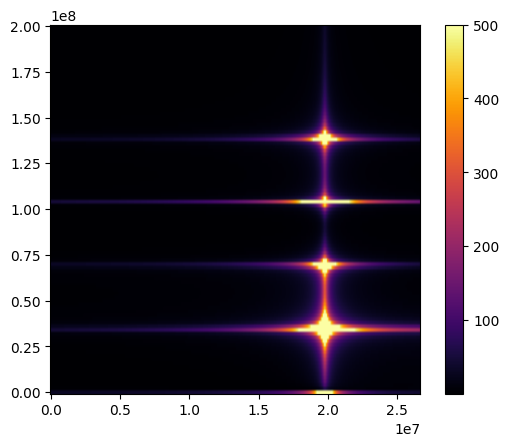

In [64]:
from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import numpy as np
from numpy.typing import NDArray
from enum import IntEnum

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import perpendicular_projection, transform_from_crystal_to_nv_coords
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [9e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.linspace(0, 0.5e-6, 1001) 
EVOLUTION_TIME_S = np.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6

class _Indices(IntEnum):
    x = 0
    y = 1
    z = 2

def imshow_with_extents(xaxis, yaxis, data: NDArray, aspect_ratio:float =1, vmin=None, vmax=None):
    if data.shape != (len(yaxis),len(xaxis)):
        raise ValueError("x-axis, y-axis shape doesn't match data")
    if len(xaxis) <= 1 or len(yaxis) <= 1:
        raise ValueError("x-axis, y-axis must have more than one data point")
    xstep = xaxis[1]-xaxis[0]
    ystep = yaxis[1]-yaxis[0]
    extents = [min(xaxis)-xstep/2, max(xaxis)+xstep/2, min(yaxis)-ystep/2, max(yaxis)+ystep/2,]
    intrinsic_aspect_ratio = (max(yaxis)-min(yaxis) + ystep)/(max(xaxis)-min(xaxis)+xstep)
    return plt.imshow(data, extent=extents, aspect=aspect_ratio/intrinsic_aspect_ratio, vmin=vmin, vmax=vmax, origin="lower", cmap="inferno")

def imshow_with_extents_and_crop(xaxis:NDArray, yaxis:NDArray, data: NDArray, aspect_ratio:float =1, xmin=None, xmax=None, ymin= None, ymax =None, vmin=None, vmax=None):
    small_quantity_to_ensure_no_cropping = 1
    if xmin==None:
        xmin = min(xaxis) - small_quantity_to_ensure_no_cropping
    if xmax==None:
        xmax = max(xaxis) + small_quantity_to_ensure_no_cropping
    if ymin==None:
        ymin = min(yaxis) - small_quantity_to_ensure_no_cropping
    if ymax==None:
        ymax = max(yaxis) + small_quantity_to_ensure_no_cropping
    x_mask = np.all(np.array([(xmin <= xaxis), xaxis <= xmax]), axis=0)
    y_mask = np.all(np.array([(ymin <= yaxis), yaxis <= ymax]), axis=0)
    imshow_with_extents(xaxis[x_mask], yaxis[y_mask],abs(data[y_mask,:][:,x_mask]), vmin=vmin, vmax=vmax, aspect_ratio=aspect_ratio)

rabi_vector_hz_xtal_coords = (
        RABI_FREQ_BASE_HZ
        * MW_DIRECTION
        / np.linalg.norm(MW_DIRECTION)
    )

rabi_frequencies=[RABI_FREQ_BASE_HZ*perpendicular_projection(MW_DIRECTION, NVaxis) for NVaxis in NVaxes_100]

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_nv_single_species(NVOrientation.A, NV14HyperfineField.N14_0)
#nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(0)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

exp_param_factory.set_second_pulse_phase(np.pi)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

sq_cancelled_signal = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

# Calculate the eigenvalues that we'd like to extract
for NVaxis in NVaxes_100:
    nv_axis_unit_vector = NVaxis / np.linalg.norm(NVaxis)

    print(nv_axis_unit_vector)
    rabi_vector_hz_nv_coords = transform_from_crystal_to_nv_coords(rabi_vector_hz_xtal_coords, nv_axis_unit_vector)
    rabi_xyplane_angle_from_x_rad = np.arctan2(
        rabi_vector_hz_nv_coords[_Indices.y], rabi_vector_hz_nv_coords[_Indices.x]
    )

    b_field_vector_t_nv_coords = transform_from_crystal_to_nv_coords(
        np.array(B_FIELD_VECTOR_T), nv_axis_unit_vector
    )
    b_xyplane_angle_from_x_rad = np.arctan2(
        b_field_vector_t_nv_coords[_Indices.y], b_field_vector_t_nv_coords[_Indices.x]
    )

    e_field_vector_hz = np.diag(np.array([exy, exy, ez])) @ transform_from_crystal_to_nv_coords(
        E_FIELD_VECTOR_V_PER_CM, nv_axis_unit_vector)

    int_hamiltonian = OffAxisFieldHamiltonian.internal_hamiltonian_bare(
        e_field_vector_hz, b_field_vector_t_nv_coords, off_axis_experiment_parameters.zero_field_splitting_hz
    )
    evals, evects = OffAxisFieldHamiltonian.get_ordered_spin_1_eigensystem(int_hamiltonian)
    h_int_eigenbasis_rwa = OffAxisFieldHamiltonian.internal_hamiltonian_eigenbasis_rwa(
        evals, off_axis_experiment_parameters.zero_field_splitting_hz + off_axis_experiment_parameters.detuning_hz
    )
    print(abs(np.real_if_close((evals[2]-evals[0])/(2*np.pi), tol=1e10)))


rabifreqs=np.sort(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
ramsey_max = 30e6 # 3*np.linalg.norm(np.array(B_FIELD_VECTOR_T)*gammab) + 2*2.16e6
rabi_max = RABI_FREQ_BASE_HZ*2

fourier_transform_sq_subtracted = np.fft.fft2(off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results)
fourier_transform_sq_subtracted  = np.fft.fftshift(fourier_transform_sq_subtracted)
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(fourier_transform_sq_subtracted), ymin=0, ymax=rabi_max, xmin=0, xmax=ramsey_max, vmax=500)
plt.colorbar()

plt.show()

In [65]:
rabi_vector_hz_xtal_coords = (
        RABI_FREQ_BASE_HZ
        * MW_DIRECTION
        / np.linalg.norm(MW_DIRECTION)
    )

rabi_frequencies=[perpendicular_projection(rabi_vector_hz_xtal_coords, NVaxis) for NVaxis in NVaxes_100]

In [66]:
import numpy as np

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import transform_from_crystal_to_nv_coords
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [9e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.linspace(0, 0.5e-6, 1001) 
EVOLUTION_TIME_S = np.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
nv_ensemble.add_nv_single_species(NVOrientation.A, NV14HyperfineField.N14_0)
#nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(0)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

exp_param_factory.set_second_pulse_phase(np.pi)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

sq_cancelled_signal = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

# Calculate the eigenvalue difference that we'd like to extract
for NVaxis in NVaxes_100:
    nv_axis_unit_vector = NVaxis / np.linalg.norm(NVaxis)

    b_field_vector_t_nv_coords = transform_from_crystal_to_nv_coords(
        np.array(B_FIELD_VECTOR_T), nv_axis_unit_vector
    )

    e_field_vector_hz = np.diag(np.array([exy, exy, ez])) @ transform_from_crystal_to_nv_coords(
        E_FIELD_VECTOR_V_PER_CM, nv_axis_unit_vector)

    int_hamiltonian = OffAxisFieldHamiltonian.internal_hamiltonian_bare(
        e_field_vector_hz, b_field_vector_t_nv_coords, off_axis_experiment_parameters.zero_field_splitting_hz
    )
    evals, evects = OffAxisFieldHamiltonian.get_ordered_spin_1_eigensystem(int_hamiltonian)
    h_int_eigenbasis_rwa = OffAxisFieldHamiltonian.internal_hamiltonian_eigenbasis_rwa(
        evals, off_axis_experiment_parameters.zero_field_splitting_hz + off_axis_experiment_parameters.detuning_hz
    )
    print(abs(np.real_if_close((evals[2]-evals[0])/(2*np.pi), tol=1e10)))

# Find the Rabi frequencies
rabi_frequencies=[RABI_FREQ_BASE_HZ*perpendicular_projection(MW_DIRECTION, NVaxis) for NVaxis in NVaxes_100]

19799999.35216375
6600035.5374567155
5400063.674568134
7800014.585956869


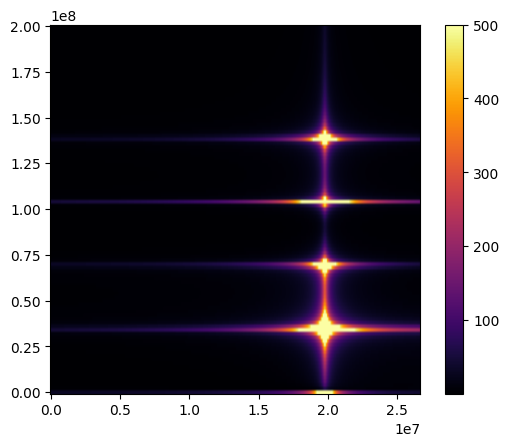

In [67]:
rabifreqs=np.sort(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
ramsey_max = 30e6 # 3*np.linalg.norm(np.array(B_FIELD_VECTOR_T)*gammab) + 2*2.16e6
rabi_max = RABI_FREQ_BASE_HZ*2

fourier_transform_sq_subtracted = np.fft.fft2(sq_cancelled_signal)
fourier_transform_sq_subtracted  = np.fft.fftshift(fourier_transform_sq_subtracted)
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(fourier_transform_sq_subtracted), ymin=0, ymax=rabi_max, xmin=0, xmax=ramsey_max, vmax=500)
plt.colorbar()

plt.show()

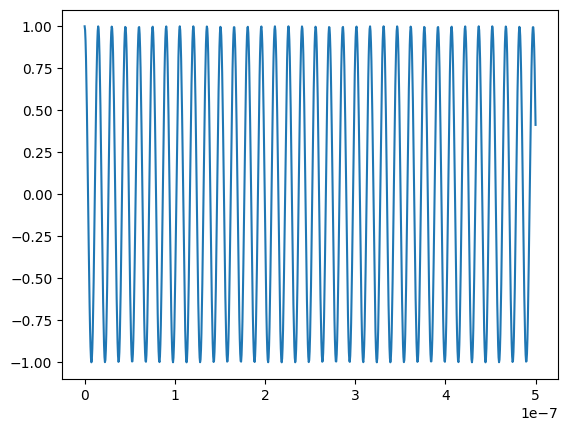

In [68]:
plt.plot(MW_PULSE_LENGTH_S,np.cos(2*np.pi*rabi_frequencies[0]* MW_PULSE_LENGTH_S))
plt.show()

In [69]:
np.cos(2*np.pi*rabi_frequencies[0]* MW_PULSE_LENGTH_S)* sq_cancelled_signal

ValueError: operands could not be broadcast together with shapes (1001,) (1001,801) 

In [ ]:
test_cos=np.cos(2*np.pi*(rabi_frequencies[0])* MW_PULSE_LENGTH_S)*np.transpose(sq_cancelled_signal)
print(test_cos.shape)
test2=np.sum(test_cos, axis=1)/np.sum(np.cos(2*np.pi*rabi_frequencies[0]* MW_PULSE_LENGTH_S)*np.cos(2*np.pi*rabi_frequencies[0]* MW_PULSE_LENGTH_S))
plt.plot(EVOLUTION_TIME_S,test2)
plt.xlim((0,.1e-5))
plt.show()

(801, 1001)


In [ ]:
def inner_product_cos_rabi_axis(rabi_frequency_hz, mw_pulse_length_s, dq_signal):
    numerator = np.sum(np.cos(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*np.transpose(dq_signal), axis=1)
    denominator = np.sum(np.cos(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*np.cos(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

def inner_product_sin_rabi_axis(rabi_frequency_hz, mw_pulse_length_s, dq_signal):
    numerator = np.sum(np.sin(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*np.transpose(dq_signal), axis=1)
    denominator = np.sum(np.sin(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*np.sin(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

def inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal):
    numerator = np.sum(func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*np.transpose(dq_signal), axis=1)
    denominator = np.sum(func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

501.47456250248183


In [ ]:
test_cos = inner_product_cos_rabi_axis(rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)
test_sin = inner_product_sin_rabi_axis(rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)
plt.plot(EVOLUTION_TIME_S, test_cos)
plt.plot(EVOLUTION_TIME_S, test_sin)
plt.show()

In [ ]:
def inner_product_cos_ramsey_axis(ramsey_freq_hz, evolution_time_s, ramsey_signal):
    numerator = np.sum(np.cos(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*ramsey_signal)
    denominator = np.sum(np.cos(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*np.cos(2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

def inner_product_sin_ramsey_axis(ramsey_freq_hz, evolution_time_s, ramsey_signal):
    numerator = np.sum(np.sin(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*ramsey_signal)
    denominator = np.sum(np.sin(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*np.sin(2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

def inner_product_func_ramsey_axis(func,ramsey_freq_hz, evolution_time_s, ramsey_signal):
    numerator = np.sum(func(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*ramsey_signal)
    denominator = np.sum(func(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*func(2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

In [ ]:
def double_inner_product(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_lengths_s, evolution_times_s, dq_signal):
    rabi_inner_product = np.sum(np.cos(2*np.pi*(rabi_frequency_hz)* mw_pulse_lengths_s)*np.transpose(dq_signal), axis=1)
    normalization_rabi = np.sum(np.cos(2*np.pi*(rabi_frequency_hz)* mw_pulse_lengths_s)*np.cos(2*np.pi*(rabi_frequency_hz)* mw_pulse_lengths_s))

    double_inner_product = np.sum(np.cos(2*np.pi*(ramsey_freq_hz)* evolution_times_s)*rabi_inner_product)
    normalization_ramsey = np.sum(np.cos(2*np.pi*(ramsey_freq_hz)* evolution_times_s)*np.cos(2*np.pi*(ramsey_freq_hz)* evolution_times_s))
    return double_inner_product/(normalization_rabi*normalization_ramsey)

In [ ]:
import time
ramsey_frequency_axis = np.linspace(1e6, 40e6, 101) 
ramsey_freqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))

t1 = time.time()
test_cos = inner_product_cos_rabi_axis(rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)
test_cos = inner_product_func_rabi_axis(np.cos,rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)
#test_sin = inner_product_sin_rabi_axis(rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)

inner_product_cos_cos_outcome = [inner_product_cos_ramsey_axis(ramsey_freq,EVOLUTION_TIME_S, test_cos) for ramsey_freq in ramsey_freqs]
inner_product_cos_cos_outcome = [inner_product_func_ramsey_axis(np.cos,ramsey_freq,EVOLUTION_TIME_S, test_cos) for ramsey_freq in ramsey_freqs]
#inner_product_sin_cos_outcome = [inner_product_cos_ramsey_axis(ramsey_freq,EVOLUTION_TIME_S, test_sin) for ramsey_freq in ramsey_freqs]
#inner_product_cos_sin_outcome = [inner_product_sin_ramsey_axis(ramsey_freq,EVOLUTION_TIME_S, test_cos) for ramsey_freq in ramsey_freqs]
#inner_product_sin_sin_outcome = [inner_product_sin_ramsey_axis(ramsey_freq,EVOLUTION_TIME_S, test_sin) for ramsey_freq in ramsey_freqs]
t2 = time.time()
#fft_cos_ipo = np.fft.fft(test_cos)
#fft_cos_ipo  = 2*np.fft.fftshift(fft_cos_ipo)/len(EVOLUTION_TIME_S)
#fft_sin_ipo = np.fft.fft(test_sin)
#fft_sin_ipo  = 2*np.fft.fftshift(fft_sin_ipo)/len(EVOLUTION_TIME_S)

inner_product_cos_cos_outcome_2 = [double_inner_product(rabi_frequencies[0], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal) for ramsey_freq in ramsey_freqs]
#plt.plot(ramsey_freqs,np.sqrt(np.abs(fft_cos_ipo)**2 + np.abs(fft_sin_ipo)**2))
#plt.plot(ramsey_freqs, np.sqrt(np.array(inner_product_cos_cos_outcome)**2 + np.array(inner_product_cos_sin_outcome)**2 +np.array(inner_product_sin_cos_outcome)**2 +np.array(inner_product_sin_sin_outcome)**2 ))
#plt.ylim((0, .005))
#plt.show()
t3 = time.time()
print(t2-t1, t3-t2)
plt.plot(ramsey_freqs, inner_product_cos_cos_outcome)
plt.plot(ramsey_freqs, inner_product_cos_cos_outcome_2)
plt.show()

0.09488391876220703 1.3695869445800781


In [ ]:
def inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=1):
    numerator = np.sum(func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*window*np.transpose(dq_signal), axis=1)
    denominator = np.sum(func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

def inner_product_func_ramsey_axis(func,ramsey_freq_hz, evolution_time_s, ramsey_signal, window=1):
    numerator = np.sum(func(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*window*ramsey_signal)
    denominator = np.sum(func(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*func(2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

def double_inner_product(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_products = [inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) for func in [np.cos, np.sin]]

    all_double_inner_products = np.array([[inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product, window=ramsey_window) for func in [np.cos, np.sin]] for rabi_inner_product in rabi_inner_products]).flatten() 
    
    return np.sqrt(np.sum(all_double_inner_products**2))

rabi_inner_product_cos = inner_product_func_rabi_axis(np.cos,rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)
rabi_inner_product_sin = inner_product_func_rabi_axis(np.sin,rabi_frequencies[0], MW_PULSE_LENGTH_S, sq_cancelled_signal)

total_inner_product = [np.sqrt(inner_product_func_ramsey_axis(np.cos,ramsey_freq,EVOLUTION_TIME_S, rabi_inner_product_cos)**2 + inner_product_func_ramsey_axis(np.sin,ramsey_freq,EVOLUTION_TIME_S, rabi_inner_product_cos)**2 + inner_product_func_ramsey_axis(np.cos,ramsey_freq,EVOLUTION_TIME_S, rabi_inner_product_sin)**2 + inner_product_func_ramsey_axis(np.sin,ramsey_freq,EVOLUTION_TIME_S, rabi_inner_product_sin)**2) for ramsey_freq in ramsey_freqs]

total_inner_product_2 = [double_inner_product(rabi_frequencies[0], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal) for ramsey_freq in ramsey_freqs]
plt.plot(ramsey_freqs, total_inner_product)
plt.plot(ramsey_freqs, total_inner_product_2)
plt.show()

In [ ]:
ramsey_freqs_fine = np.linspace(19e6, 21e6, 501)
total_inner_product_2 = [double_inner_product(rabi_frequencies[0], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal) for ramsey_freq in ramsey_freqs_fine]
#plt.plot(ramsey_freqs, total_inner_product)
plt.plot(ramsey_freqs_fine, total_inner_product_2)
plt.scatter([20e6], double_inner_product(rabi_frequencies[0], 20e6, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal))
plt.show()

In [ ]:
from scipy.optimize import minimize
def inner_product_to_minimize( ramsey_freq_hz, rabi_frequency_hz, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window):
    return 1/double_inner_product(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)
output = minimize(inner_product_to_minimize, [20e6], (rabi_frequencies[0], EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, 1, np.exp(-EVOLUTION_TIME_S/T2STAR_S)), method='Nelder-Mead')



In [ ]:
print(output.x)

[19791808.96282196]


In [ ]:
from scipy.signal import windows
plt.plot(windows.blackman(101))
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import windows

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import transform_from_crystal_to_nv_coords, perpendicular_projection
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [1e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.linspace(0, 1e-6, 1001) 
EVOLUTION_TIME_S = np.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6

# Watch out I added a minus sign in the normalization so that it would work with complex exponentials...
def inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=1):
    numerator = np.sum(func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*window*np.transpose(dq_signal), axis=1)
    denominator = np.sum(func(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*func(-2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

# Watch out I added a minus sign in the normalization so that it would work with complex exponentials...
def inner_product_func_ramsey_axis(func,ramsey_freq_hz, evolution_time_s, ramsey_signal, window=1):
    numerator = np.sum(func(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*window*ramsey_signal)
    denominator = np.sum(func(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*func(-2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

def negative_complex_exponential(phase):
    return np.exp(-1.0j*phase)

def double_inner_product(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_products = [inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) for func in [np.cos, np.sin]]

    all_double_inner_products = np.array([[inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product, window=ramsey_window) for func in [np.cos, np.sin]] for rabi_inner_product in rabi_inner_products]).flatten() 
    
    return np.sqrt(np.sum(all_double_inner_products**2))

def double_inner_product_complex(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_product = inner_product_func_rabi_axis(negative_complex_exponential,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) 
    double_inner_product = inner_product_func_ramsey_axis(negative_complex_exponential,ramsey_freq_hz,evolution_time_s, rabi_inner_product, window=ramsey_window) 
    return np.abs(double_inner_product)

def double_inner_product_first_quadrant(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_product_cos, rabi_inner_product_sin = [inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) for func in [np.cos, np.sin]]

    double_inner_product_cos_cos, double_inner_product_cos_sin = [inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product_cos, window=ramsey_window) for func in [np.cos, np.sin]]
    double_inner_product_sin_cos, double_inner_product_sin_sin = [inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product_sin, window=ramsey_window) for func in [np.cos, np.sin]]
    
    return np.sqrt((double_inner_product_cos_cos-double_inner_product_sin_sin)**2 + (double_inner_product_cos_sin + double_inner_product_sin_cos)**2)

def double_inner_product_all_terms(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_product_cos, rabi_inner_product_sin = [inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) for func in [np.cos, np.sin]]

    double_inner_product_cos_cos, double_inner_product_cos_sin = [inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product_cos, window=ramsey_window) for func in [np.cos, np.sin]]
    double_inner_product_sin_cos, double_inner_product_sin_sin = [inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product_sin, window=ramsey_window) for func in [np.cos, np.sin]]
    
    return double_inner_product_cos_cos, double_inner_product_sin_sin, double_inner_product_cos_sin, double_inner_product_sin_cos

def double_inner_product_mean_subtracted(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_products = [inner_product_func_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) for func in [np.cos, np.sin]]

    rabi_inner_products = [rabi_inner_products[i] - np.mean(rabi_inner_products[i]) for i in range(len(rabi_inner_products))]
    all_double_inner_products = np.array([[inner_product_func_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product, window=ramsey_window) for func in [np.cos, np.sin]] for rabi_inner_product in rabi_inner_products]).flatten() 
    
    return np.sqrt(np.sum(all_double_inner_products**2))

def inner_product_to_minimize( ramsey_freq_hz, rabi_frequency_hz, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window):
    return 1/double_inner_product_mean_subtracted(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
#nv_ensemble.add_nv_single_species(NVOrientation.A, NV14HyperfineField.N14_plus)
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(0)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

exp_param_factory.set_second_pulse_phase(np.pi)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

sq_cancelled_signal = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

In [ ]:
from numpy.typing import NDArray
def imshow_with_extents(xaxis, yaxis, data: NDArray, aspect_ratio:float =1, vmin=None, vmax=None):
    if data.shape != (len(yaxis),len(xaxis)):
        raise ValueError("x-axis, y-axis shape doesn't match data")
    if len(xaxis) <= 1 or len(yaxis) <= 1:
        raise ValueError("x-axis, y-axis must have more than one data point")
    xstep = xaxis[1]-xaxis[0]
    ystep = yaxis[1]-yaxis[0]
    extents = [min(xaxis)-xstep/2, max(xaxis)+xstep/2, min(yaxis)-ystep/2, max(yaxis)+ystep/2,]
    intrinsic_aspect_ratio = (max(yaxis)-min(yaxis) + ystep)/(max(xaxis)-min(xaxis)+xstep)
    return plt.imshow(data, extent=extents, aspect=aspect_ratio/intrinsic_aspect_ratio, vmin=vmin, vmax=vmax, origin="lower", cmap="inferno")

def imshow_with_extents_and_crop(xaxis:NDArray, yaxis:NDArray, data: NDArray, aspect_ratio:float =1, xmin=None, xmax=None, ymin= None, ymax =None, vmin=None, vmax=None):
    small_quantity_to_ensure_no_cropping = 1
    if xmin==None:
        xmin = min(xaxis) - small_quantity_to_ensure_no_cropping
    if xmax==None:
        xmax = max(xaxis) + small_quantity_to_ensure_no_cropping
    if ymin==None:
        ymin = min(yaxis) - small_quantity_to_ensure_no_cropping
    if ymax==None:
        ymax = max(yaxis) + small_quantity_to_ensure_no_cropping
    x_mask = np.all(np.array([(xmin <= xaxis), xaxis <= xmax]), axis=0)
    y_mask = np.all(np.array([(ymin <= yaxis), yaxis <= ymax]), axis=0)
    imshow_with_extents(xaxis[x_mask], yaxis[y_mask],abs(data[y_mask,:][:,x_mask]), vmin=vmin, vmax=vmax, aspect_ratio=aspect_ratio)

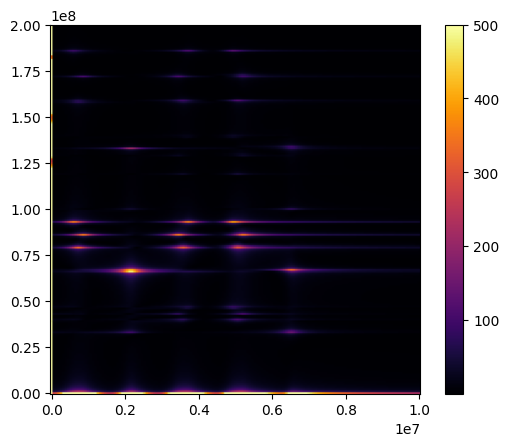

In [ ]:
rabifreqs=np.sort(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
ramsey_max = 10e6 # 3*np.linalg.norm(np.array(B_FIELD_VECTOR_T)*gammab) + 2*2.16e6
rabi_max = RABI_FREQ_BASE_HZ*2

fourier_transform_sq_subtracted = np.fft.fft2(sq_cancelled_signal)
fourier_transform_sq_subtracted  = np.fft.fftshift(fourier_transform_sq_subtracted)
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(fourier_transform_sq_subtracted), ymin=0, ymax=rabi_max, xmin=0, xmax=ramsey_max, vmax=500)
plt.colorbar()

/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_83197/2299084575.py:36: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


575.7737730825252
4.706261422238178e-05


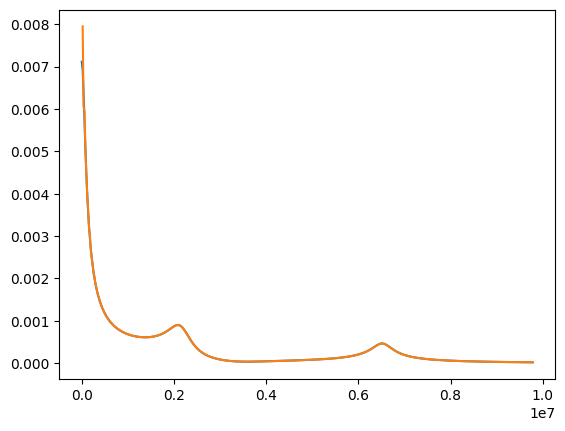

In [ ]:
from bff_simulator.constants import f_h
larmor_freqs_hz = []
bz_values_nv_coords_t = []
for NVaxis in NVaxes_100:
    nv_axis_unit_vector = NVaxis / np.linalg.norm(NVaxis)

    b_field_vector_t_nv_coords = transform_from_crystal_to_nv_coords(
        np.array(B_FIELD_VECTOR_T), nv_axis_unit_vector
    ) + np.array([0,0,f_h/gammab])
    
    bz_values_nv_coords_t.append(b_field_vector_t_nv_coords[2])

    e_field_vector_hz = np.diag(np.array([exy, exy, ez])) @ transform_from_crystal_to_nv_coords(
        E_FIELD_VECTOR_V_PER_CM, nv_axis_unit_vector)

    int_hamiltonian = OffAxisFieldHamiltonian.internal_hamiltonian_bare(
        e_field_vector_hz, b_field_vector_t_nv_coords, off_axis_experiment_parameters.zero_field_splitting_hz
    )
    evals, evects = OffAxisFieldHamiltonian.get_ordered_spin_1_eigensystem(int_hamiltonian)
    h_int_eigenbasis_rwa = OffAxisFieldHamiltonian.internal_hamiltonian_eigenbasis_rwa(
        evals, off_axis_experiment_parameters.zero_field_splitting_hz + off_axis_experiment_parameters.detuning_hz
    )
    larmor_freqs_hz.append( abs(np.real_if_close((evals[2]-evals[0])/(2*np.pi), tol=1e10)))
# Find the Rabi frequencies
rabi_frequencies=[RABI_FREQ_BASE_HZ*perpendicular_projection(MW_DIRECTION, NVaxis) for NVaxis in NVaxes_100]

rabi_window = windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window =  np.exp(-EVOLUTION_TIME_S/T2STAR_S)

optimal_value = minimize(inner_product_to_minimize, [2*(gammab*bz_values_nv_coords_t[0]+f_h)], (rabi_frequencies[0], EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window), method='Nelder-Mead')

ramsey_freqs_fine = np.linspace(0 *larmor_freqs_hz[0], 1.5*larmor_freqs_hz[0], 501)
#total_inner_product_1 = [double_inner_product_mean_subtracted(rabi_frequencies[0], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, ramsey_window=ramsey_window, rabi_window=rabi_window) for ramsey_freq in ramsey_freqs_fine]
total_inner_product_1 = [double_inner_product_complex(rabi_frequencies[0], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, ramsey_window=ramsey_window, rabi_window=rabi_window) for ramsey_freq in ramsey_freqs_fine]
total_inner_product_2 = [double_inner_product_first_quadrant(rabi_frequencies[0], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, ramsey_window=ramsey_window, rabi_window=rabi_window) for ramsey_freq in ramsey_freqs_fine]
plt.plot(ramsey_freqs_fine, 4*np.array(total_inner_product_1))
plt.plot(ramsey_freqs_fine, total_inner_product_2)
#plt.scatter([larmor_freqs_hz[0]], [double_inner_product(rabi_frequencies[0], larmor_freqs_hz[0], MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal,ramsey_window=ramsey_window, rabi_window = rabi_window)])
#plt.scatter(optimal_value.x,[double_inner_product(rabi_frequencies[0], (optimal_value.x)[0], MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal,ramsey_window=ramsey_window, rabi_window = rabi_window)])
print(1e9*(optimal_value.x[0] - larmor_freqs_hz[0])/(2*gammab))
print(1e9*(bz_values_nv_coords_t[0] - larmor_freqs_hz[0]/(2*gammab)))
plt.show()

617.974093242681
4.706261422238178e-05


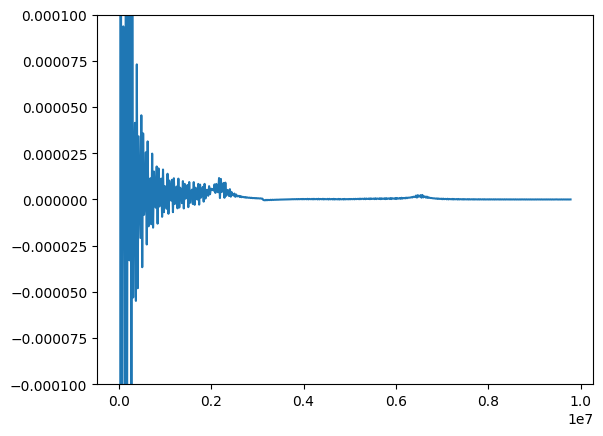

In [ ]:
plt.plot(ramsey_freqs_fine, 4*np.array(total_inner_product_1) - np.array(total_inner_product_2))
plt.ylim(-1e-4, 1e-4)
#plt.scatter([larmor_freqs_hz[0]], [double_inner_product(rabi_frequencies[0], larmor_freqs_hz[0], MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal,ramsey_window=ramsey_window, rabi_window = rabi_window)])
#plt.scatter(optimal_value.x,[double_inner_product(rabi_frequencies[0], (optimal_value.x)[0], MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal,ramsey_window=ramsey_window, rabi_window = rabi_window)])
print(1e9*(optimal_value.x[0] - larmor_freqs_hz[0])/(2*gammab))
print(1e9*(bz_values_nv_coords_t[0] - larmor_freqs_hz[0]/(2*gammab)))
plt.show()

In [ ]:
def double_inner_product_complex_mean_subtracted(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1):
    rabi_inner_product = inner_product_func_rabi_axis(negative_complex_exponential,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) 
    rabi_inner_product = rabi_inner_product - np.mean(rabi_inner_product)
    double_inner_product = inner_product_func_ramsey_axis(negative_complex_exponential,ramsey_freq_hz,evolution_time_s, rabi_inner_product, window=ramsey_window) 
    return np.abs(double_inner_product)

def inner_product_to_minimize(ramsey_freq_hz, rabi_frequency_hz, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window):
    return 1/double_inner_product_first_quadrant(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)

optimal_value = minimize(inner_product_to_minimize, [2*(gammab*bz_values_nv_coords_t[0]+f_h)], (rabi_frequencies[0], EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window), method='Nelder-Mead')
print(1e9*(optimal_value.x[0] - larmor_freqs_hz[0])/(2*gammab))

-53.790852432417715


In [ ]:
def inner_product_to_minimize(x, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window):
    ramsey_freq_hz, rabi_frequency_hz = x
    return 1/double_inner_product(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)

optimal_value = minimize(inner_product_to_minimize, [2*(gammab*bz_values_nv_coords_t[0]+f_h),rabi_frequencies[0]], (EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window), method='Nelder-Mead')

In [ ]:
optimal_value.x[1]

np.float64(66698886.330459565)

In [ ]:
print(1e9*(optimal_value.x[0] - larmor_freqs_hz[0])/(2*gammab))

-59.17962763399734


In [ ]:
total_ inner_product = [double_inner_product_complex(optimal_value.x[1], ramsey_freq, MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, ramsey_window=ramsey_window, rabi_window=rabi_window) for ramsey_freq in ramsey_freqs_fine]

## Trying inversions the second time

In [398]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import windows

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import transform_from_crystal_to_nv_coords, perpendicular_projection
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [1e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 1600e-9, 2.5e-9)#np.linspace(0, 0.5e-6, 1001) 
EVOLUTION_TIME_S = np.arange(0, 20e-6, 20e-9) #p.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
#nv_ensemble.add_n14_triplet(NVOrientation.A)
#nv_ensemble.add_n14_triplet(NVOrientation.C)
#nv_ensemble.add_n14_triplet(NVOrientation.D)
#nv_ensemble.add_nv_single_species(NVOrientation.B, NV14HyperfineField.N14_plus)
#nv_ensemble.add_nv_single_species(NVOrientation.B, NV14HyperfineField.N14_0)
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(0)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

exp_param_factory.set_second_pulse_phase(np.pi)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

sq_cancelled_signal = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

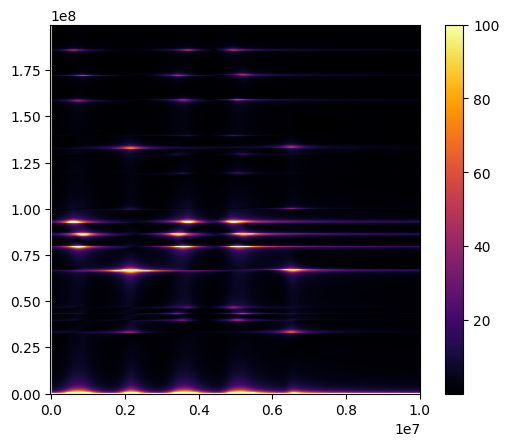

In [357]:
rabifreqs=np.sort(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
ramsey_max = 10e6 # 3*np.linalg.norm(np.array(B_FIELD_VECTOR_T)*gammab) + 2*2.16e6
rabi_max = RABI_FREQ_BASE_HZ*2

fourier_transform_sq_subtracted = np.fft.fft2(sq_cancelled_signal)
fourier_transform_sq_subtracted  = np.fft.fftshift(fourier_transform_sq_subtracted)
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(fourier_transform_sq_subtracted), ymin=0, ymax=rabi_max, xmin=0, xmax=ramsey_max, vmax=100)
plt.colorbar()

In [540]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import windows

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import transform_from_crystal_to_nv_coords, perpendicular_projection
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [1e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 1600e-9, 2.5e-9)#np.linspace(0, 0.5e-6, 1001) 
EVOLUTION_TIME_S = np.arange(0, 20e-6, 20e-9) #p.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6


exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)

exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)

off_axis_solver = LiouvillianSolver()

signal_by_orientation = []

for orientation in NVOrientation:
    nv_ensemble = HomogeneousEnsemble()
    nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
    nv_ensemble.t2_star_s = T2STAR_S
    nv_ensemble.add_n14_triplet(orientation)
    nv_ensemble.mw_direction = MW_DIRECTION

    exp_param_factory.set_second_pulse_phase(0)
    off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
    
    off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

    exp_param_factory.set_second_pulse_phase(np.pi)
    off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
    off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

    sq_cancelled_signal_by_orientation = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results
    signal_by_orientation.append(sq_cancelled_signal_by_orientation)

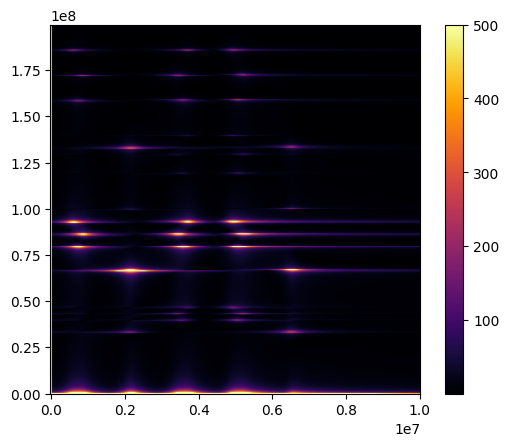

In [359]:
rabifreqs=np.sort(np.fft.fftfreq(len(MW_PULSE_LENGTH_S), MW_PULSE_LENGTH_S[1]-MW_PULSE_LENGTH_S[0]))
ramseyfreqs = np.sort(np.fft.fftfreq(len(EVOLUTION_TIME_S), EVOLUTION_TIME_S[1]-EVOLUTION_TIME_S[0]))
ramsey_max = 10e6 # 3*np.linalg.norm(np.array(B_FIELD_VECTOR_T)*gammab) + 2*2.16e6
rabi_max = RABI_FREQ_BASE_HZ*2

total_signal_all_orientations = np.sum(signal_by_orientation,axis=0)

fourier_transform_sq_subtracted = np.fft.fft2(total_signal_all_orientations)
fourier_transform_sq_subtracted  = np.fft.fftshift(fourier_transform_sq_subtracted)
imshow_with_extents_and_crop(ramseyfreqs,rabifreqs, abs(fourier_transform_sq_subtracted), ymin=0, ymax=rabi_max, xmin=0, xmax=ramsey_max, vmax=500)
plt.colorbar()

In [ ]:
larmor_freqs_hz = []
bz_values_nv_coords_t = []
for NVaxis in NVaxes_100:
    bz_values_for_this_axis = []
    larmor_freqs_hz = []
    for m_hyperfine in [-1, 0, 1]:
        nv_axis_unit_vector = NVaxis / np.linalg.norm(NVaxis)

        b_field_vector_t_nv_coords = transform_from_crystal_to_nv_coords(
            np.array(B_FIELD_VECTOR_T), nv_axis_unit_vector
        ) + np.array([0,0,m_hyperfine * f_h/gammab])
        
        bz_values_for_this_axis.append(b_field_vector_t_nv_coords[2])

        e_field_vector_hz = np.diag(np.array([exy, exy, ez])) @ transform_from_crystal_to_nv_coords(
            E_FIELD_VECTOR_V_PER_CM, nv_axis_unit_vector)

        int_hamiltonian = OffAxisFieldHamiltonian.internal_hamiltonian_bare(
            e_field_vector_hz, b_field_vector_t_nv_coords, off_axis_experiment_parameters.zero_field_splitting_hz
        )
        evals, evects = OffAxisFieldHamiltonian.get_ordered_spin_1_eigensystem(int_hamiltonian)
        h_int_eigenbasis_rwa = OffAxisFieldHamiltonian.internal_hamiltonian_eigenbasis_rwa(
            evals, off_axis_experiment_parameters.zero_field_splitting_hz + off_axis_experiment_parameters.detuning_hz
        )
        larmor_freqs_hz.append( abs(np.real_if_close((evals[2]-evals[0])/(2*np.pi), tol=1e10)))
    bz_values_nv_coords_t.append(bz_values_for_this_axis)
    larmor_freqs_hz.append(larmor_freqs_hz)
# Find the Rabi frequencies
rabi_frequencies=[RABI_FREQ_BASE_HZ*perpendicular_projection(MW_DIRECTION, NVaxis) for NVaxis in NVaxes_100]

In [361]:
def inner_product_sinusoid_rabi_axis(sinusoid_function,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=1):
    numerator = np.sum(sinusoid_function(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*window*np.transpose(dq_signal), axis=1)
    denominator = np.sum(sinusoid_function(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*sinusoid_function(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

def inner_product_sinusoid_ramsey_axis(sinusoid_function,ramsey_freq_hz, evolution_time_s, ramsey_signal, window=1):
    numerator = np.sum(sinusoid_function(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*window*ramsey_signal)
    denominator = np.sum(sinusoid_function(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*sinusoid_function(2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

def inner_product_exponential_rabi_axis(rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=1):
    numerator = np.sum(np.exp(-2.0j*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*window*np.transpose(dq_signal), axis=1)
    denominator = len(mw_pulse_length_s)
    return numerator/denominator

def inner_product_exponential_ramsey_axis(ramsey_freq_hz, evolution_time_s, ramsey_signal, window=1):
    numerator = np.sum(np.exp(-2.0j*np.pi*(ramsey_freq_hz)* evolution_time_s)*window*ramsey_signal)
    denominator = len(evolution_time_s)
    return numerator/denominator

def double_inner_product_all_sinusoids(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1, mean_subtracted=False):
    rabi_inner_product_cos, rabi_inner_product_sin = [inner_product_sinusoid_rabi_axis(func,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) for func in [np.cos, np.sin]]
    
    if mean_subtracted:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)
        rabi_inner_product_sin = rabi_inner_product_sin - np.mean(rabi_inner_product_sin)

    double_inner_product_cos_cos, double_inner_product_cos_sin = [inner_product_sinusoid_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product_cos, window=ramsey_window) for func in [np.cos, np.sin]]
    double_inner_product_sin_cos, double_inner_product_sin_sin = [inner_product_sinusoid_ramsey_axis(func,ramsey_freq_hz,evolution_time_s, rabi_inner_product_sin, window=ramsey_window) for func in [np.cos, np.sin]]
    
    return double_inner_product_cos_cos, double_inner_product_sin_sin, double_inner_product_cos_sin, double_inner_product_sin_cos

def double_inner_product_exponential(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1, mean_subtracted=False):
    rabi_inner_product_exp = inner_product_exponential_rabi_axis(rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window)
    if mean_subtracted:
        rabi_inner_product_exp = rabi_inner_product_exp-np.mean(rabi_inner_product_exp)

    double_inner_product_exp = inner_product_exponential_ramsey_axis(ramsey_freq_hz, evolution_time_s, rabi_inner_product_exp, window=ramsey_window)
    return double_inner_product_exp

def exp_inner_product_to_minimize(ramsey_freq_hz, rabi_frequency_hz, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window, mean_subtracted):
    double_inner_product_exp_magnitude = np.abs(double_inner_product_exponential(rabi_frequency_hz, ramsey_freq_hz[0], mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=mean_subtracted))
    return 1/double_inner_product_exp_magnitude

def quadrature_sum_inner_product_to_minimize(ramsey_freq_hz, rabi_frequency_hz, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window, mean_subtracted):
    squared_sum = np.sum(np.array(double_inner_product_all_sinusoids(rabi_frequency_hz,ramsey_freq_hz[0],mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=mean_subtracted))**2) 
    return 1/squared_sum

def cos_cos_inner_product_to_minimize(ramsey_freq_hz, rabi_frequency_hz, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window, mean_subtracted):
    rabi_inner_product_cos= inner_product_sinusoid_rabi_axis(np.cos,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window)
    if mean_subtracted:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)
    cos_cos_inner_product = inner_product_sinusoid_ramsey_axis(np.cos,ramsey_freq_hz[0], evolution_time_s, rabi_inner_product_cos, window=ramsey_window)
    return 1/np.abs(cos_cos_inner_product)


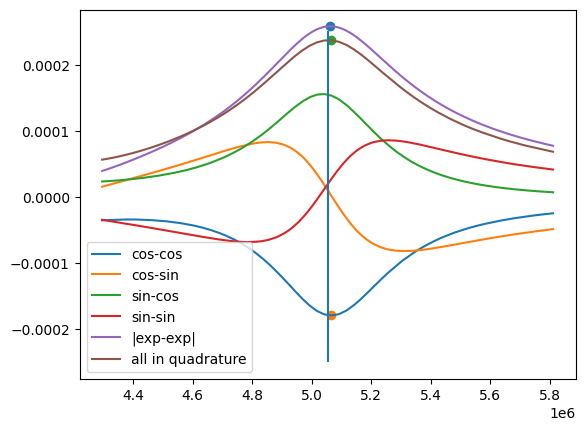

In [366]:
rabi_window = windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window =  np.exp(-EVOLUTION_TIME_S/T2STAR_S)

orientation = 1
hyperfine = 0

optimal_value_exp = minimize(exp_inner_product_to_minimize, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine]))], (rabi_frequencies[orientation], EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window, False), method='Nelder-Mead')
optimal_value_quad = minimize(quadrature_sum_inner_product_to_minimize, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine]))], (rabi_frequencies[orientation], EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window, False), method='Nelder-Mead')
optimal_value_cos = minimize(cos_cos_inner_product_to_minimize, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine]))], (rabi_frequencies[orientation], EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window, False), method='Nelder-Mead')

ramsey_freqs_fine = np.linspace(.85 *larmor_freqs_hz[orientation][hyperfine], 1.15*larmor_freqs_hz[orientation][hyperfine], 501)

double_inner_product_cos_cos, double_inner_product_sin_sin, double_inner_product_cos_sin, double_inner_product_sin_cos = np.array([double_inner_product_all_sinusoids(rabi_frequencies[orientation],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window) for ramsey_freq_hz in ramsey_freqs_fine]).transpose()
double_inner_product_exp_mag = [4*np.abs(double_inner_product_exponential(rabi_frequencies[orientation],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)) for ramsey_freq_hz in ramsey_freqs_fine]
plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")
plt.plot(ramsey_freqs_fine, double_inner_product_cos_sin, label = "cos-sin")
plt.plot(ramsey_freqs_fine, double_inner_product_sin_cos, label = "sin-cos")
plt.plot(ramsey_freqs_fine, double_inner_product_sin_sin, label = "sin-sin")
plt.plot(ramsey_freqs_fine, double_inner_product_exp_mag, label="|exp-exp|")
plt.plot(ramsey_freqs_fine, np.sqrt(double_inner_product_cos_cos**2 + double_inner_product_cos_sin**2 + double_inner_product_sin_cos**2 + double_inner_product_sin_sin**2), label = "all in quadrature")
plt.scatter(optimal_value_exp.x[0], 4*np.abs(double_inner_product_exponential(rabi_frequencies[orientation],optimal_value_exp.x[0],MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)))
plt.scatter(optimal_value_cos.x[0], double_inner_product_all_sinusoids(rabi_frequencies[orientation], optimal_value_cos.x[0], MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window)[0])
plt.scatter(optimal_value_quad.x[0], np.sqrt(np.sum(np.array(double_inner_product_all_sinusoids(rabi_frequencies[orientation], optimal_value_quad.x[0], MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window))**2)))

plt.vlines([larmor_freqs_hz[orientation][hyperfine]], [-.00025], [0.000251])
plt.legend()


### Looking at background

/var/folders/zr/h37q9z9d0hj5lbz2g9qb1b180000gn/T/ipykernel_83197/1819191139.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return numerator/denominator


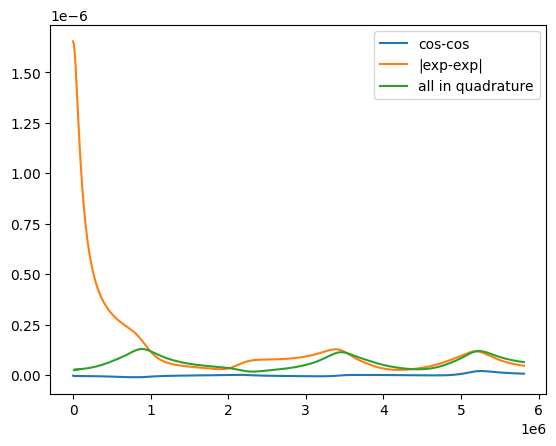

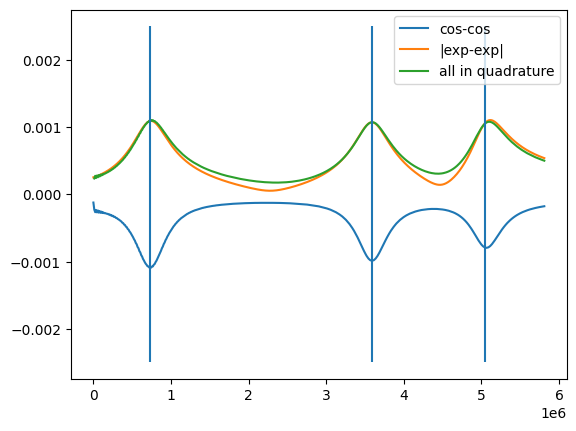

In [367]:
rabi_window = windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window =  np.exp(-EVOLUTION_TIME_S/T2STAR_S)

orientation = 1
hyperfine = 0

ramsey_freqs_fine = np.linspace(0 *larmor_freqs_hz[orientation][hyperfine], 1.15*larmor_freqs_hz[orientation][hyperfine], 501)

sq_cancelled_signal_bkgd = np.sum(signal_by_orientation,axis=0) - signal_by_orientation[orientation]
sq_cancelled_signal_target = signal_by_orientation[orientation]

double_inner_product_cos_cos_bk, double_inner_product_sin_sin_bk, double_inner_product_cos_sin_bk, double_inner_product_sin_cos_bk = np.array([double_inner_product_all_sinusoids(rabi_frequencies[orientation],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_bkgd, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine]).transpose()
double_inner_product_exp_mag_bk = [4*np.abs(double_inner_product_exponential(rabi_frequencies[orientation],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_bkgd, rabi_window=rabi_window, ramsey_window=ramsey_window)) for ramsey_freq_hz in ramsey_freqs_fine]
plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos_bk, label = "cos-cos")
plt.plot(ramsey_freqs_fine, double_inner_product_exp_mag_bk, label="|exp-exp|")
plt.plot(ramsey_freqs_fine, np.sqrt(double_inner_product_cos_cos_bk**2 + double_inner_product_cos_sin_bk**2 + double_inner_product_sin_cos_bk**2 + double_inner_product_sin_sin_bk**2), label = "all in quadrature")
plt.legend()
plt.show()

double_inner_product_cos_cos, double_inner_product_sin_sin, double_inner_product_cos_sin, double_inner_product_sin_cos = np.array([double_inner_product_all_sinusoids(rabi_frequencies[orientation],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_target, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine]).transpose()
double_inner_product_exp_mag = [4*np.abs(double_inner_product_exponential(rabi_frequencies[orientation],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_target, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted = True)) for ramsey_freq_hz in ramsey_freqs_fine]
plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")
plt.plot(ramsey_freqs_fine, double_inner_product_exp_mag, label="|exp-exp|")
plt.plot(ramsey_freqs_fine, np.sqrt(double_inner_product_cos_cos**2 + double_inner_product_cos_sin**2 + double_inner_product_sin_cos**2 + double_inner_product_sin_sin**2), label = "all in quadrature")

plt.vlines(larmor_freqs_hz[orientation], [-.0025], [.0025])
plt.legend()

### Looking at fitting Lorentzians

In [407]:
def cos_cos_inner_product_to_minimize_rabi_ramsey(ramsey_rabi, evolution_time_s, mw_pulse_length_s, dq_signal, rabi_window, ramsey_window, mean_subtracted):
    rabi_inner_product_cos= inner_product_sinusoid_rabi_axis(np.cos,ramsey_rabi[1], mw_pulse_length_s, dq_signal, window=rabi_window)
    if mean_subtracted:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)
    cos_cos_inner_product = inner_product_sinusoid_ramsey_axis(np.cos,ramsey_rabi[0], evolution_time_s, rabi_inner_product_cos, window=ramsey_window)
    return 1/np.abs(cos_cos_inner_product)

In [544]:
ramsey_freqs_fine = np.linspace(0.1 *larmor_freqs_hz[orientation][hyperfine], 1.5*larmor_freqs_hz[orientation][hyperfine], 1001)
rabi_window = 1 #windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window = 1# np.exp(-EVOLUTION_TIME_S/T2STAR_S)

orientation = 1
hyperfine = 0
sq_cancelled_signal_target = signal_by_orientation[orientation]

optimal_value_cos = minimize(cos_cos_inner_product_to_minimize_rabi_ramsey, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine])),rabi_frequencies[orientation]], ( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal_target, rabi_window, ramsey_window, False), method='Nelder-Mead')
print(optimal_value_cos.x)

double_inner_product_cos_cos, _, _, _ = np.array([double_inner_product_all_sinusoids(optimal_value_cos.x[1],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_target, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine]).transpose()

[ 5035548.77052295 79325351.1953555 ]


0
[ 738797.28687836 3589887.77427079 5054343.682187  ]
[-34.60934951 -60.4002569   22.5849512 ]


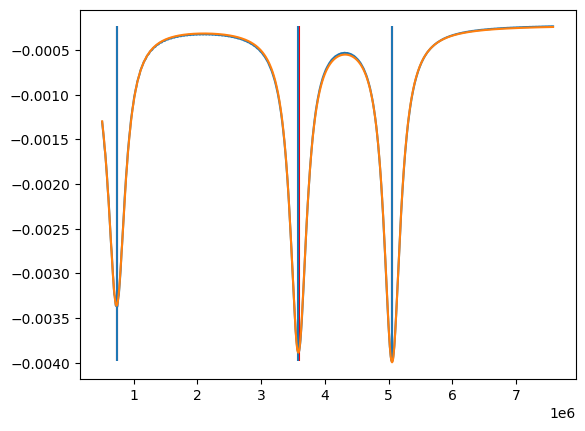

In [465]:
from lmfit import Model, Parameters, report_fit
from lmfit.models import LorentzianModel
from scipy.signal import find_peaks


plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")

max_inner_product = max(double_inner_product_cos_cos)
min_inner_product = min(double_inner_product_cos_cos)

peaks = find_peaks(-double_inner_product_cos_cos, height=(max_inner_product-min_inner_product)/3, prominence=(max_inner_product-min_inner_product)/3)
#plt.vlines(ramsey_freqs_fine[peaks[0]], [min_inner_product],[max_inner_product])
plt.vlines(larmor_freqs_hz[orientation], [min_inner_product],[max_inner_product], color='red')
def offset(x, offset_value):
    return offset_value

peak_heights = peaks[1]['peak_heights']
peak_locations = ramsey_freqs_fine[peaks[0]]
print(np.argmin(peak_locations))
print(peak_locations)

peak1 = LorentzianModel(prefix="p0_")
peak2 = LorentzianModel(prefix="p1_")
peak3 = LorentzianModel(prefix="p2_")
offset_model = Model(offset)
three_peak_model = peak1  + peak2 + peak3 + offset_model
params = three_peak_model.make_params()
params["offset_value"].value=max_inner_product
for i in range(3):
    params[f"p{i}_fwhm"].value=1/(np.pi*T2STAR_S)
    params[f"p{i}_amplitude"].value= -peak_heights[i]
    params[f"p{i}_center"].value = ramsey_freqs_fine[peaks[0][i]]

fit_result = three_peak_model.fit(double_inner_product_cos_cos, params, x=ramsey_freqs_fine)
fit_peaks = []
for i in range(3):
    fit_peaks.append(fit_result.best_values[f"p{i}_center"])
plt.vlines(fit_peaks, [min_inner_product],[max_inner_product])

print(1e9*(np.sort(np.array(fit_peaks)) - np.sort(larmor_freqs_hz[orientation]))/(2*gammab))
plt.plot(ramsey_freqs_fine,fit_result.best_fit)

In [387]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import windows

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import transform_from_crystal_to_nv_coords, perpendicular_projection
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [1e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 1600e-9, 2.5e-9)#np.linspace(0, 0.5e-6, 1001) 
EVOLUTION_TIME_S = np.arange(0, 20e-6, 20e-9) #p.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
#nv_ensemble.add_n14_triplet(NVOrientation.A)
#nv_ensemble.add_n14_triplet(NVOrientation.C)
#nv_ensemble.add_n14_triplet(NVOrientation.D)
nv_ensemble.add_nv_single_species(NVOrientation.B, NV14HyperfineField.N14_minus)
#nv_ensemble.add_nv_single_species(NVOrientation.B, NV14HyperfineField.N14_0)
#nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(0)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

exp_param_factory.set_second_pulse_phase(np.pi)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

sq_cancelled_signal = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

In [388]:
ramsey_freqs_fine = np.linspace(0.1 *larmor_freqs_hz[orientation][hyperfine], 1.5*larmor_freqs_hz[orientation][hyperfine], 1001)
rabi_window = 1 #windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window = 1# np.exp(-EVOLUTION_TIME_S/T2STAR_S)

orientation = 1
hyperfine = 0

optimal_value_cos = minimize(cos_cos_inner_product_to_minimize_rabi_ramsey, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine])),rabi_frequencies[orientation]], ( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal, rabi_window, ramsey_window, False), method='Nelder-Mead')
print(optimal_value_cos.x)

double_inner_product_cos_cos, _, _, _ = np.array([double_inner_product_all_sinusoids(optimal_value_cos.x[1],ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine]).transpose()

[ 5036470.2175192  79338989.34608585]


0
[np.float64(5053541.690330058)]
[np.float64(5053333.015583881), np.float64(733333.3820815312), np.float64(3586666.45096859)]
[7.70805079e+04 2.61717678e+04 3.72314349e+00]


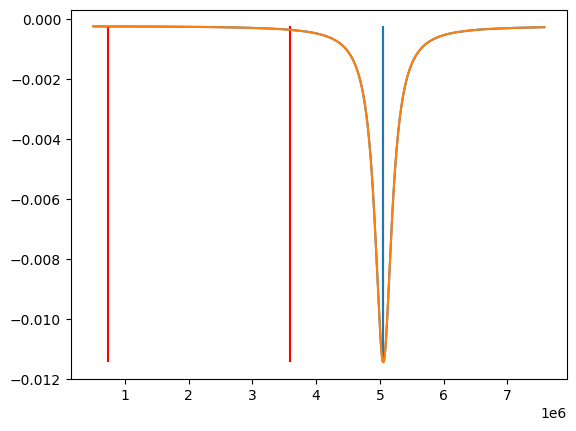

In [397]:
from lmfit import Model, Parameters, report_fit
from lmfit.models import LorentzianModel
from scipy.signal import find_peaks


plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")

max_inner_product = max(double_inner_product_cos_cos)
min_inner_product = min(double_inner_product_cos_cos)

peaks = find_peaks(-double_inner_product_cos_cos, height=(max_inner_product-min_inner_product)/3, prominence=(max_inner_product-min_inner_product)/3)
#plt.vlines(ramsey_freqs_fine[peaks[0]], [min_inner_product],[max_inner_product])
plt.vlines(larmor_freqs_hz[orientation], [min_inner_product],[max_inner_product], color='red')
def offset(x, offset_value):
    return offset_value

peak_heights = peaks[1]['peak_heights']
peak_locations = ramsey_freqs_fine[peaks[0]]
print(np.argmin(peak_locations))

peak1 = LorentzianModel(prefix="p0_")
offset_model = Model(offset)
three_peak_model = peak1  + offset_model
params = three_peak_model.make_params()
params["offset_value"].value=max_inner_product
for i in range(1):
    params[f"p{i}_fwhm"].value=1/(np.pi*T2STAR_S)
    params[f"p{i}_amplitude"].value= -peak_heights[i]
    params[f"p{i}_center"].value = ramsey_freqs_fine[peaks[0][i]]

fit_result = three_peak_model.fit(double_inner_product_cos_cos, params, x=ramsey_freqs_fine)
fit_peaks = []
for i in range(1):
    fit_peaks.append(fit_result.best_values[f"p{i}_center"])
plt.vlines(fit_peaks, [min_inner_product],[max_inner_product])
print(fit_peaks)
print(larmor_freqs_hz[orientation])
print(1e9*(np.sort(np.array(fit_peaks)) - np.sort(larmor_freqs_hz[orientation]))/(2*gammab))
plt.plot(ramsey_freqs_fine,fit_result.best_fit)

## Doing inner products at the effective Rabi frequency

In [580]:
def inner_product_sinusoid_rabi_axis(sinusoid_function,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=1):
    numerator = np.sum(sinusoid_function(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*window*np.transpose(dq_signal), axis=1)
    denominator = np.sum(sinusoid_function(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s)*sinusoid_function(2*np.pi*(rabi_frequency_hz)* mw_pulse_length_s))
    return numerator/denominator

def inner_product_sinusoid_ramsey_axis(sinusoid_function,ramsey_freq_hz, evolution_time_s, ramsey_signal, window=1):
    numerator = np.sum(sinusoid_function(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*window*ramsey_signal)
    denominator = np.sum(sinusoid_function(2*np.pi*(ramsey_freq_hz)* evolution_time_s)*sinusoid_function(2*np.pi*(ramsey_freq_hz)* evolution_time_s))
    return numerator/denominator

# Define separately just to make things faster
def double_inner_product_cos_cos_function(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1, mean_subtracted=False):
    rabi_inner_product_cos=inner_product_sinusoid_rabi_axis(np.cos,rabi_frequency_hz, mw_pulse_length_s, dq_signal, window=rabi_window) 
    
    if mean_subtracted:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)

    double_inner_product_cos_cos = inner_product_sinusoid_ramsey_axis(np.cos,ramsey_freq_hz,evolution_time_s, rabi_inner_product_cos, window=ramsey_window)
    return double_inner_product_cos_cos

(0.0, 1e-05)

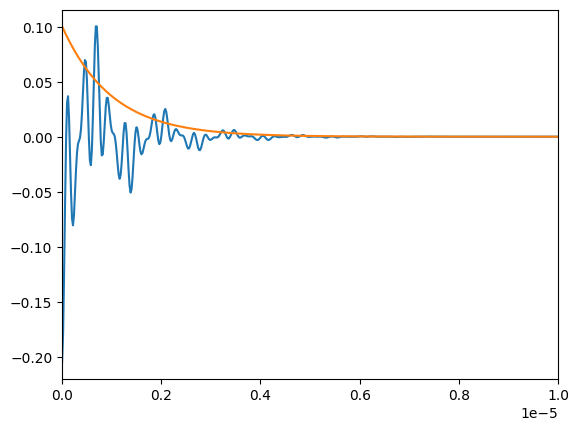

In [578]:
orientation = 1
signal_in_ramsey_time = inner_product_sinusoid_rabi_axis(np.cos, rabi_frequencies[orientation], MW_PULSE_LENGTH_S, signal_by_orientation[orientation])
signal_in_ramsey_time = signal_in_ramsey_time - np.mean(signal_in_ramsey_time)
plt.plot(EVOLUTION_TIME_S, signal_in_ramsey_time)
plt.plot(EVOLUTION_TIME_S, (max(signal_in_ramsey_time)-signal_in_ramsey_time[-1])*np.exp(-2*EVOLUTION_TIME_S/(T2STAR_S))+ signal_in_ramsey_time[-1])
plt.xlim((0, 10e-6))

[ 5035548.77052295 79325351.1953555 ]


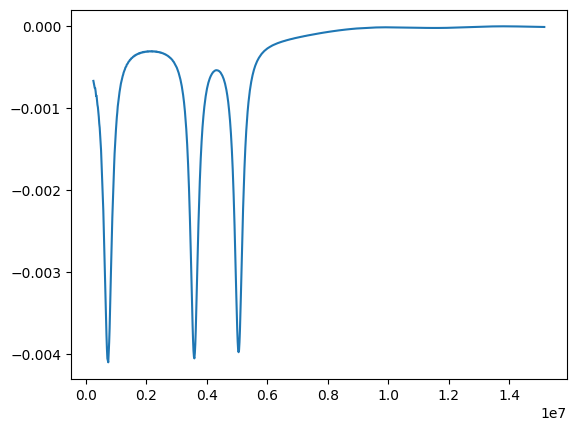

In [581]:

orientation = 1
hyperfine = 0

sq_cancelled_signal_target = signal_by_orientation[orientation]

ramsey_freqs_fine = np.linspace(0.05 *larmor_freqs_hz[orientation][hyperfine], 3*larmor_freqs_hz[orientation][hyperfine], 1001)
rabi_window = 1 #windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window = 1 # np.exp(-EVOLUTION_TIME_S/(2*T2STAR_S))


optimal_value_cos = minimize(cos_cos_inner_product_to_minimize_rabi_ramsey, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine])),rabi_frequencies[orientation]], ( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal_target, rabi_window, ramsey_window, False), method='Nelder-Mead')
print(optimal_value_cos.x)

double_inner_product_cos_cos = np.array([double_inner_product_cos_cos_function(np.sqrt(rabi_frequencies[orientation]**2 + ramsey_freq_hz**2),ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_target, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine])
plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos)

[ 744608.61984628 3591909.10747702 5052827.68228232]
[-11.08321608  -4.77742299   7.17234776]


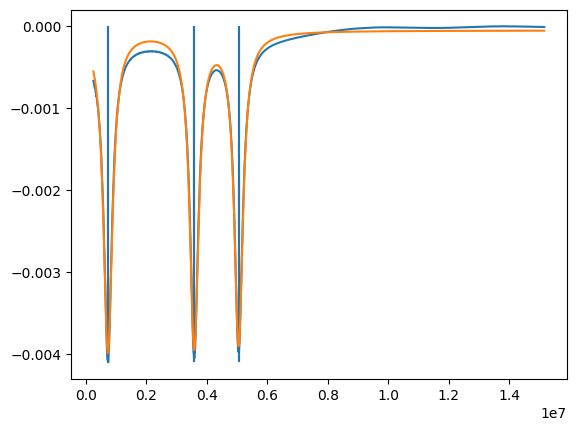

In [582]:
from lmfit import Model, Parameters, report_fit
from lmfit.models import LorentzianModel
from scipy.signal import find_peaks


plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")

max_inner_product = max(double_inner_product_cos_cos)
min_inner_product = min(double_inner_product_cos_cos)

peaks = find_peaks(-double_inner_product_cos_cos, height=(-min_inner_product)/3,prominence=(-min_inner_product)/3)
#plt.vlines(ramsey_freqs_fine[peaks[0]], [min_inner_product],[max_inner_product])
plt.vlines(larmor_freqs_hz[orientation], [min_inner_product],[max_inner_product], color='red')
peak_heights = peaks[1]['peak_heights']
peak_locations = ramsey_freqs_fine[peaks[0]]
print(peak_locations)
def offset(x, offset_value):
    return offset_value

def lorentzian(x, center, fwhm, amplitude):
    return amplitude / (1 + 4*(x-center)**2/fwhm**2)

peak0 = Model(lorentzian, prefix="p0_")
peak1 = Model(lorentzian, prefix="p1_")
peak2 = Model(lorentzian, prefix="p2_")
zero_peak = Model(lorentzian, prefix="zero_")

offset_model = Model(offset)
three_peak_model = peak0  + peak1 + peak2 + offset_model + zero_peak
params = three_peak_model.make_params()
params["offset_value"].value=0
for i in range(3):
    params[f"p{i}_fwhm"].value=2/(np.pi*T2STAR_S)
    params[f"p{i}_amplitude"].value= min_inner_product
    params[f"p{i}_center"].value = ramsey_freqs_fine[peaks[0][i]]

params[f"zero_fwhm"].value = 2/(np.pi*T2STAR_S)
params["zero_amplitude"].value = 0*(max_inner_product-min_inner_product)
params["zero_amplitude"].vary=False
params["zero_center"].value=0
params["zero_center"].vary=False
#plt.plot(ramsey_freqs_fine, three_peaks.eval(params, x=ramsey_freqs_fine))

fit_result = three_peak_model.fit(double_inner_product_cos_cos, params, x=ramsey_freqs_fine)
fit_peaks = []
for i in range(3):
    fit_peaks.append(fit_result.best_values[f"p{i}_center"])
plt.vlines(fit_peaks, [min_inner_product],[max_inner_product])

print(1e9*(np.sort(np.array(fit_peaks)) - np.sort(larmor_freqs_hz[orientation]))/(2*gammab))
plt.plot(ramsey_freqs_fine,fit_result.best_fit)

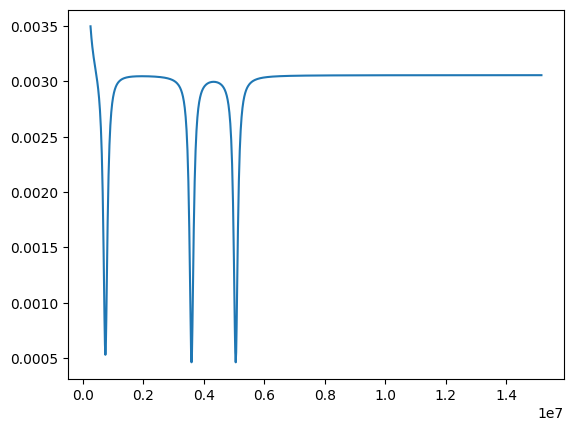

In [539]:
def offset(x, offset_value):
    return offset_value

def lorentzian(x, center, fwhm, amplitude):
    return amplitude / (1 + 4*(x-center)**2/fwhm**2)

peak0 = Model(lorentzian, prefix="p0_")
peak1 = Model(lorentzian, prefix="p1_")
peak2 = Model(lorentzian, prefix="p2_")
zero_peak = Model(lorentzian, prefix="zero_")

offset_model = Model(offset)
three_peak_model = peak0  + peak1 + peak2 + offset_model + zero_peak
params = three_peak_model.make_params()
params["offset_value"].value=max_inner_product
for i in range(3):
    params[f"p{i}_fwhm"].value=1/(np.pi*T2STAR_S)
    params[f"p{i}_amplitude"].value= min_inner_product
    params[f"p{i}_center"].value = ramsey_freqs_fine[peaks[0][i]]

params[f"zero_fwhm"].value = 1/(np.pi*T2STAR_S)
params["zero_amplitude"].value = (max_inner_product-min_inner_product)
params["zero_center"].value=0
params["zero_center"].vary=False



## Constraining eigenvalues relative to each other

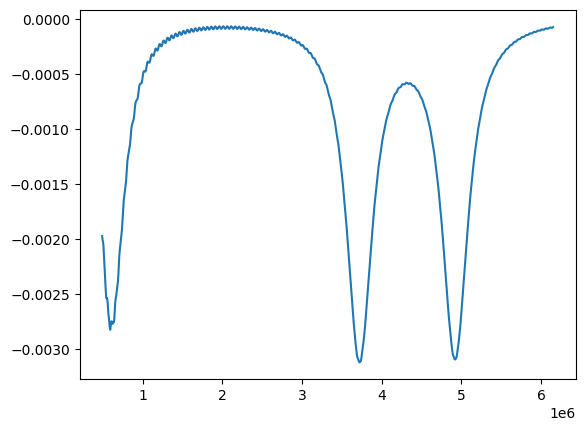

In [634]:

orientation = 2
hyperfine = 0

sq_cancelled_signal_target = signal_by_orientation[orientation]

ramsey_freqs_fine = np.linspace(0.1 *larmor_freqs_hz[orientation][hyperfine], 1.25*larmor_freqs_hz[orientation][hyperfine], 1001)
rabi_window = 1 #windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window = np.exp(-EVOLUTION_TIME_S/(2*T2STAR_S))


#optimal_value_cos = minimize(cos_cos_inner_product_to_minimize_rabi_ramsey, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine])),rabi_frequencies[orientation]], ( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal_target, rabi_window, ramsey_window, False), method='Nelder-Mead')
#print(optimal_value_cos.x)

double_inner_product_cos_cos = np.array([double_inner_product_cos_cos_function(np.sqrt(rabi_frequencies[orientation]**2 + ramsey_freq_hz**2),ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal_target, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=False) for ramsey_freq_hz in ramsey_freqs_fine])
plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos)

[3722717.75736465 4922213.67918517]
[ 2.07643087 -2.07382163  2.08371065]


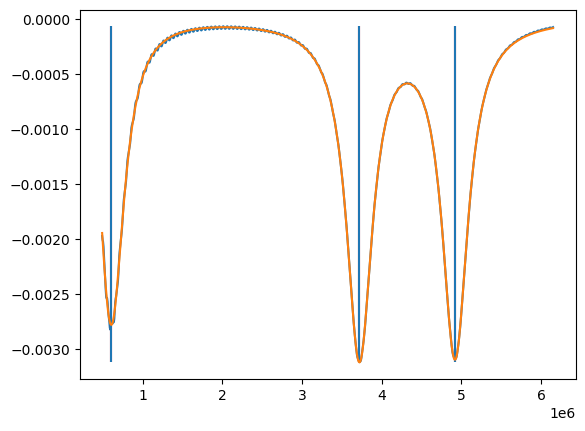

In [635]:
from lmfit import Model, Parameters, report_fit
from lmfit.models import LorentzianModel
from scipy.signal import find_peaks


plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")

max_inner_product = max(double_inner_product_cos_cos)
min_inner_product = min(double_inner_product_cos_cos)

peaks = find_peaks(-double_inner_product_cos_cos, height=(-min_inner_product)/3,prominence=(-min_inner_product)/3)
#plt.vlines(ramsey_freqs_fine[peaks[0]], [min_inner_product],[max_inner_product])
plt.vlines(larmor_freqs_hz[orientation], [min_inner_product],[max_inner_product], color='red')
peak_heights = peaks[1]['peak_heights']
peak_locations = ramsey_freqs_fine[peaks[0]]
print(peak_locations)

def offset(x, offset_value):
    return offset_value

def lorentzian(x, center, fwhm, amplitude):
    return amplitude / (1 + 4*(x-center)**2/fwhm**2)

peak0 = Model(lorentzian, prefix="p0_")
peak1 = Model(lorentzian, prefix="p1_")
peak2 = Model(lorentzian, prefix="p2_")
zero_peak = Model(lorentzian, prefix="zero_")

offset_model = Model(offset)
three_peak_model = peak0  + peak1 + peak2 + offset_model + zero_peak
params = three_peak_model.make_params()
params["offset_value"].value=0
for i in range(3):
    params[f"p{i}_fwhm"].value=2/(np.pi*T2STAR_S)
    params[f"p{i}_amplitude"].value= min_inner_product
    if i == 0:
        params[f"p{i}_center"].value = ramsey_freqs_fine[peaks[0][-1]]
    else:
        params[f"p{i}_center"].expr = f"abs(p0_center - 2*{i}*{f_h})"

params[f"zero_fwhm"].value = 2/(np.pi*T2STAR_S)
params["zero_amplitude"].value = (max_inner_product-min_inner_product)
params["zero_amplitude"].vary=True
params["zero_center"].value=0
params["zero_center"].vary=False
#plt.plot(ramsey_freqs_fine, three_peaks.eval(params, x=ramsey_freqs_fine))

fit_result = three_peak_model.fit(double_inner_product_cos_cos, params, x=ramsey_freqs_fine)
fit_peaks = []
for i in range(3):
    fit_peaks.append(fit_result.best_values[f"p{i}_center"])
plt.vlines(fit_peaks, [min_inner_product],[max_inner_product])

print(1e9*(np.sort(np.array(fit_peaks)) - np.sort(larmor_freqs_hz[orientation]))/(2*gammab))
plt.plot(ramsey_freqs_fine,fit_result.best_fit)

## Looking at windowing

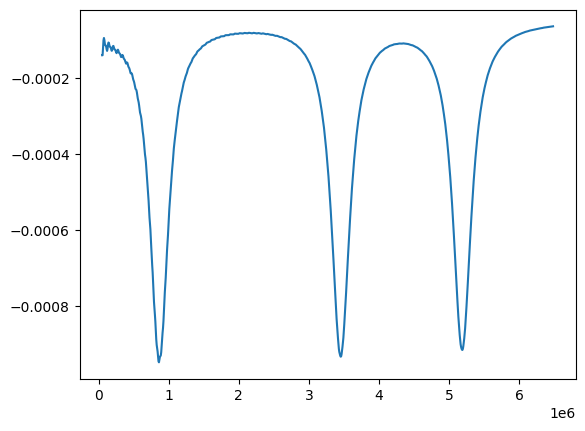

In [766]:

orientation = 3
hyperfine = 0

#sq_cancelled_signal_target = signal_by_orientation[orientation]
#sq_cancelled_signal_total = np.sum(np.array(signal_by_orientation), axis=0)

ramsey_freqs_fine = np.linspace(0.01 *larmor_freqs_hz[orientation][hyperfine], 1.25*larmor_freqs_hz[orientation][hyperfine], 1001)
rabi_window =  windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window = 1 #np.exp(-EVOLUTION_TIME_S/(2*T2STAR_S))


#optimal_value_cos = minimize(cos_cos_inner_product_to_minimize_rabi_ramsey, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine])),rabi_frequencies[orientation]], ( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal_target, rabi_window, ramsey_window, False), method='Nelder-Mead')
#print(optimal_value_cos.x)

double_inner_product_cos_cos = np.array([double_inner_product_cos_cos_function(np.sqrt(rabi_frequencies[orientation]**2 + ramsey_freq_hz**2),ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine])
plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos)

[ 862231.41489934 3454112.32595263 5190608.22169552]
[ 0.80537311 -0.80221564  0.81128608]


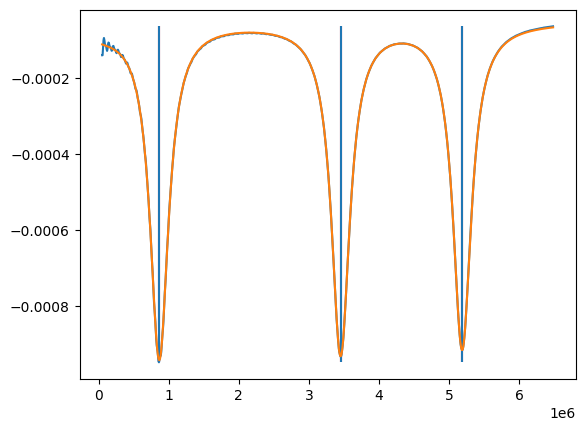

In [749]:
from lmfit import Model, Parameters, report_fit
from lmfit.models import LorentzianModel
from scipy.signal import find_peaks


plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")

max_inner_product = max(double_inner_product_cos_cos)
min_inner_product = min(double_inner_product_cos_cos)

peaks = find_peaks(-double_inner_product_cos_cos, height=(-min_inner_product)/3,prominence=(-min_inner_product)/3)
#plt.vlines(ramsey_freqs_fine[peaks[0]], [min_inner_product],[max_inner_product])
plt.vlines(larmor_freqs_hz[orientation], [min_inner_product],[max_inner_product], color='red')
peak_heights = peaks[1]['peak_heights']
peak_locations = ramsey_freqs_fine[peaks[0]]
print(peak_locations)

def offset(x, offset_value):
    return offset_value

def lorentzian(x, center, fwhm, amplitude):
    return amplitude / (1 + 4*(x-center)**2/fwhm**2)
    # return amplitude*np.sin((x-center)/fwhm)/((x-center)/fwhm)
peak0 = Model(lorentzian, prefix="p0_")
peak1 = Model(lorentzian, prefix="p1_")
peak2 = Model(lorentzian, prefix="p2_")
zero_peak = Model(lorentzian, prefix="zero_")

offset_model = Model(offset)
three_peak_model = peak0  + peak1 + peak2 + offset_model + zero_peak
params = three_peak_model.make_params()
params["offset_value"].value=0
for i in range(3):
    params[f"p{i}_fwhm"].value=1/(np.pi*T2STAR_S)
    params[f"p{i}_amplitude"].value= min_inner_product
    if i == 0:
        params[f"p{i}_center"].value = ramsey_freqs_fine[peaks[0][-1]]
    else:
        params[f"p{i}_center"].expr = f"abs(p0_center - 2*{i}*{f_h})"

params[f"zero_fwhm"].value = 2/(np.pi*T2STAR_S)
params["zero_amplitude"].value = (max_inner_product)
params["zero_amplitude"].vary=True
params["zero_center"].value=0
params["zero_center"].vary=False
#plt.plot(ramsey_freqs_fine, three_peaks.eval(params, x=ramsey_freqs_fine))

fit_result = three_peak_model.fit(double_inner_product_cos_cos, params, x=ramsey_freqs_fine)
fit_peaks = []
for i in range(3):
    fit_peaks.append(fit_result.best_values[f"p{i}_center"])
plt.vlines(fit_peaks, [min_inner_product],[max_inner_product])

print(1e9*(np.sort(np.array(fit_peaks)) - np.sort(larmor_freqs_hz[orientation]))/(2*gammab))
plt.plot(ramsey_freqs_fine,fit_result.best_fit)

(-0.001, 0.001)

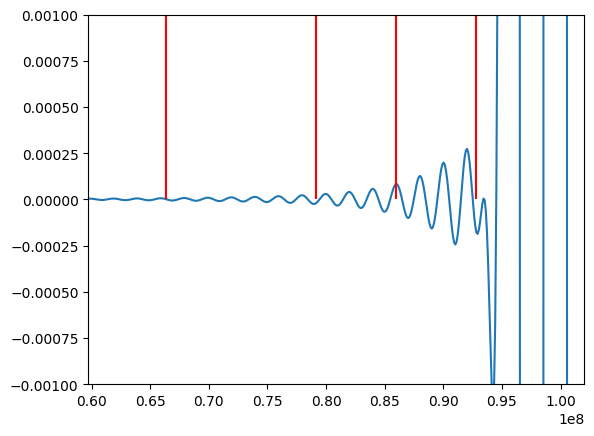

In [706]:
orientation = 0

mw_durations_s = np.arange(0, 500e-9, 2.5e-9)
rabi_freqs = np.arange(0.9*min(rabi_frequencies), 2.1*max(rabi_frequencies), 1e5)
rabi_window=np.cos(1.5*2*np.pi*rabi_frequencies[orientation]*mw_durations_s)* windows.blackman(len(mw_durations_s))
ip_window=[inner_product_sinusoid_ramsey_axis(np.cos,rabi_freq,mw_durations_s, rabi_window) for rabi_freq in rabi_freqs]
plt.plot(rabi_freqs, ip_window)
plt.vlines(rabi_frequencies, [0], [max(ip_window)], color ='red')
plt.xlim((0.9*min(rabi_frequencies), 1.1*max(rabi_frequencies)))
plt.ylim((-1e-3, 1e-3))

## Time to systematize this inversion - Rabi_effective cut with constrained fit of all three hyperfine lines

What can we get directly from the simulation? What parameters will we need to specify for the inversion?

In [870]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import windows

from bff_simulator.abstract_classes.abstract_ensemble import NV14HyperfineField, NVOrientation
from bff_simulator.constants import exy, ez, NVaxes_100, gammab, f_h
from bff_simulator.homogeneous_ensemble import HomogeneousEnsemble
from bff_simulator.liouvillian_solver import LiouvillianSolver
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParametersFactory
from bff_simulator.simulator import Simulation
from bff_simulator.vector_manipulation import transform_from_crystal_to_nv_coords, perpendicular_projection
from bff_simulator.offaxis_field_hamiltonian_constructor import OffAxisFieldHamiltonian

MW_DIRECTION = np.array([0.97203398, 0.2071817, 0.11056978]) # Vincent's old "magic angle"
MW_DIRECTION = np.array([0.20539827217056314, 0.11882075246379901, 0.9714387158093318]) # Lily's new "magic angle"
E_FIELD_VECTOR_V_PER_CM = 0* np.array([1e5, 3e5, 0]) / exy
B_FIELD_VECTOR_T = [1e6/(gammab*np.sqrt(3)) * x for x in [1, 1.1, 1.2]]
RABI_FREQ_BASE_HZ = 100e6
DETUNING_HZ = 0e6
SECOND_PULSE_PHASE = 0
MW_PULSE_LENGTH_S = np.arange(0, 500e-9, 2.5e-9)#np.linspace(0, 0.5e-6, 1001) 
EVOLUTION_TIME_S = np.arange(0, 15e-6, 20e-9) #p.linspace(0, 15e-6, 801) 
T2STAR_S = 2e-6

nv_ensemble = HomogeneousEnsemble()
nv_ensemble.efield_splitting_hz = np.linalg.norm(E_FIELD_VECTOR_V_PER_CM) * exy
nv_ensemble.t2_star_s = T2STAR_S
#nv_ensemble.add_n14_triplet(NVOrientation.A)
#nv_ensemble.add_n14_triplet(NVOrientation.C)
#nv_ensemble.add_n14_triplet(NVOrientation.D)
#nv_ensemble.add_nv_single_species(NVOrientation.B, NV14HyperfineField.N14_plus)
#nv_ensemble.add_nv_single_species(NVOrientation.B, NV14HyperfineField.N14_0)
nv_ensemble.add_full_diamond_populations()
nv_ensemble.mw_direction = MW_DIRECTION

exp_param_factory = OffAxisFieldExperimentParametersFactory()
exp_param_factory.set_base_rabi_frequency(RABI_FREQ_BASE_HZ)
exp_param_factory.set_mw_direction(MW_DIRECTION)
exp_param_factory.set_e_field_v_per_m(E_FIELD_VECTOR_V_PER_CM)
exp_param_factory.set_b_field_vector(B_FIELD_VECTOR_T)
exp_param_factory.set_detuning(DETUNING_HZ)
exp_param_factory.set_second_pulse_phase(0)
exp_param_factory.set_mw_pulse_lengths(MW_PULSE_LENGTH_S)
exp_param_factory.set_evolution_times(EVOLUTION_TIME_S)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()

off_axis_solver = LiouvillianSolver()

off_axis_simulation_0_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

exp_param_factory.set_second_pulse_phase(np.pi)
off_axis_experiment_parameters = exp_param_factory.get_experiment_parameters()
off_axis_simulation_pi_phase = Simulation(off_axis_experiment_parameters, nv_ensemble, off_axis_solver)

sq_cancelled_signal = off_axis_simulation_0_phase.ms0_results + off_axis_simulation_pi_phase.ms0_results

In [781]:
def double_cosine_inner_product2(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1, mean_subtracted=False):
    rabi_inner_product_cos=inner_product_sinusoid(np.cos,rabi_frequency_hz, mw_pulse_length_s, rabi_window*np.transpose(dq_signal), axis=1) 
    
    if mean_subtracted:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)

    double_inner_product_cos_cos = inner_product_sinusoid(np.cos,ramsey_freq_hz,evolution_time_s, ramsey_window*rabi_inner_product_cos, axis=0)
    return double_inner_product_cos_cos

Presumably we will know the experiment parameters (except the magnetic and electric field) so we should be able to access those -- those should be passed into the inversion. 

In [774]:
from dataclasses import dataclass
@dataclass
class InnerProductSettings: # Settings shared by all inner products performed in a given inversion protocol
    mw_pulse_durations_s: NDArray
    free_evolution_times_s: NDArray
    rabi_window: str = "boxcar" # Best option: "blackman"
    ramsey_window: str = "boxcar" # Best option: "boxcar"
    subtract_mean: bool = True  # Best option: True
    use_effective_rabi_frequency: bool = True  # Best option: True

In [ ]:
from bff_simulator.offaxis_field_experiment_parameters import OffAxisFieldExperimentParameters


def inner_product_sinusoid(sinusoid_function:np.ufunc, inner_product_freq_hz:float, sample_times_s:NDArray, dq_signal:NDArray, axis:int =0):
    numerator = np.sum(sinusoid_function(2*np.pi*(inner_product_freq_hz)* sample_times_s)*dq_signal, axis=axis)
    denominator = np.sum(sinusoid_function(2*np.pi*(inner_product_freq_hz)* sample_times_s)*sinusoid_function(2*np.pi*( inner_product_freq_hz)* sample_times_s))
    return numerator/denominator

def double_cosine_inner_product(dq_signal:NDArray, rabi_freq_hz:float, ramsey_freq_hz:float, ips: InnerProductSettings):
    if ips.use_effective_rabi_frequency:
        rabi_freq_hz = np.sqrt(rabi_freq_hz**2 + ramsey_freq_hz**2)
    
    rabi_window = windows.get_window(ips.rabi_window, len(ips.mw_pulse_durations_s))

    rabi_inner_product_cos=inner_product_sinusoid(np.cos,rabi_freq_hz, ips.mw_pulse_durations_s, rabi_window*np.transpose(dq_signal), axis=1) 
    
    if ips.subtract_mean:
        rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)

    ramsey_window = windows.get_window(ips.ramsey_window, len(ips.free_evolution_times_s))
    double_inner_product_cos_cos = inner_product_sinusoid(np.cos, ramsey_freq_hz, ips.free_evolution_times_s, ramsey_window*rabi_inner_product_cos, axis=0)
    
    return double_inner_product_cos_cos

# Older version...
#def double_cosine_inner_product2(rabi_frequency_hz, ramsey_freq_hz, mw_pulse_length_s, evolution_time_s, dq_signal, rabi_window=1, ramsey_window=1, mean_subtracted=False):
#    rabi_inner_product_cos=inner_product_sinusoid(np.cos,rabi_frequency_hz, mw_pulse_length_s, rabi_window*np.transpose(dq_signal), axis=1) 
#    
#    if mean_subtracted:
#       rabi_inner_product_cos = rabi_inner_product_cos - np.mean(rabi_inner_product_cos)
#
#    double_inner_product_cos_cos = inner_product_sinusoid(np.cos,ramsey_freq_hz,evolution_time_s, ramsey_window*rabi_inner_product_cos, axis=0)
#    return double_inner_product_cos_cos, rabi_inner_product_cos

def double_cosine_inner_product_vs_ramsey(dq_ms0_fluorescence:NDArray, rabi_freq_hz: float, ramsey_freq_range_hz: NDArray, inner_product_settings: InnerProductSettings):
    inner_product_vs_ramsey = []
    for ramsey_freq_hz in ramsey_freq_range_hz:
        inner_product_vs_ramsey.append(double_cosine_inner_product(dq_ms0_fluorescence, rabi_freq_hz, ramsey_freq_hz, inner_product_settings))
    return np.array(inner_product_vs_ramsey)
    


In [ ]:
def get_bare_rabi_frequencies(experiment_parameters:OffAxisFieldExperimentParameters):
    base_rabi_hz = experiment_parameters.rabi_frequency_base_hz
    mw_direction = experiment_parameters.mw_direction
    return [base_rabi_hz*perpendicular_projection(mw_direction, NVaxis) for NVaxis in NVaxes_100]

def get_true_eigenvalues(off_axis_experiment_parameters:OffAxisFieldExperimentParameters):
    larmor_freqs_hz = []
    bz_values_nv_coords_t = []
    for NVaxis in NVaxes_100:
        bz_values_for_this_axis = []
        larmor_freqs_for_this_axis = []
        for m_hyperfine in [-1, 0, 1]:
            nv_axis_unit_vector = NVaxis / np.linalg.norm(NVaxis)

            b_field_vector_t_nv_coords = transform_from_crystal_to_nv_coords(
                np.array(off_axis_experiment_parameters.b_field_vector_t), nv_axis_unit_vector
            ) + np.array([0,0,m_hyperfine * f_h/gammab])
            
            bz_values_for_this_axis.append(b_field_vector_t_nv_coords[2])

            e_field_vector_hz = np.diag(np.array([exy, exy, ez])) @ transform_from_crystal_to_nv_coords(
                off_axis_experiment_parameters.e_field_vector_v_per_m, nv_axis_unit_vector)

            int_hamiltonian = OffAxisFieldHamiltonian.internal_hamiltonian_bare(
                e_field_vector_hz, b_field_vector_t_nv_coords, off_axis_experiment_parameters.zero_field_splitting_hz
            )
            evals, _ = OffAxisFieldHamiltonian.get_ordered_spin_1_eigensystem(int_hamiltonian)
            larmor_freqs_for_this_axis.append(abs((evals[2]-evals[0])/(2*np.pi)))
        bz_values_nv_coords_t.append(bz_values_for_this_axis)
        larmor_freqs_hz.append(larmor_freqs_for_this_axis)
    return larmor_freqs_hz, bz_values_nv_coords_t



In [883]:
from lmfit import Model, Parameters, report_fit
from lmfit.models import LorentzianModel
from scipy.signal import find_peaks

def offset(x, offset_value):
    return offset_value

def lorentzian(x, center, fwhm, amplitude):
    return amplitude / (1 + 4*(x-center)**2/fwhm**2)

def set_up_three_peak_model(max_inner_product, min_inner_product, rightmost_peak_location, t2star_s):
    peak0 = Model(lorentzian, prefix="p0_")
    peak1 = Model(lorentzian, prefix="p1_")
    peak2 = Model(lorentzian, prefix="p2_")
    zero_peak = Model(lorentzian, prefix="zero_")
    offset_model = Model(offset)
    three_peak_model = peak0  + peak1 + peak2 + offset_model + zero_peak
    params = three_peak_model.make_params()
    params["offset_value"].value=0
    for i in range(3):
        params[f"p{i}_fwhm"].value=2/(np.pi*t2star_s)
        params[f"p{i}_amplitude"].value= min_inner_product
        if i == 0:
            params[f"p{i}_center"].value = rightmost_peak_location
        else:
            params[f"p{i}_center"].expr = f"abs(p0_center - 2*{i}*{f_h})"

    params[f"zero_fwhm"].value = 2/(np.pi*t2star_s)
    params["zero_amplitude"].value = (max_inner_product)
    params["zero_amplitude"].vary=True
    params["zero_center"].value=0
    params["zero_center"].vary=False
    return three_peak_model, params

def fit_constrained_hyperfine_peaks(ramsey_freqs_fine, double_inner_product_cos_cos, t2star_s=2e-6, height_factor=1/3, prominence_factor=1/3):

    max_inner_product = max(double_inner_product_cos_cos)
    min_inner_product = min(double_inner_product_cos_cos)

    peaks = find_peaks(-double_inner_product_cos_cos, height=(-min_inner_product)*height_factor,prominence=(-min_inner_product)*prominence_factor)
    rightmost_peak_location = ramsey_freqs_fine[peaks[0][-1]]

    three_peak_model, params = set_up_three_peak_model(max_inner_product, min_inner_product, rightmost_peak_location, t2star_s)

    result = three_peak_model.fit(double_inner_product_cos_cos, params, x=ramsey_freqs_fine)
    return result


def plot_fit_vs_inner_product(ramsey_freqs_fine, double_inner_product_cos_cos, fit_result):
    plt.vlines(fit_peaks, [min_inner_product],[max_inner_product])
    plt.plot(ramsey_freqs_fine, double_inner_product_cos_cos, label = "cos-cos")    
    plt.plot(ramsey_freqs_fine,fit_result.best_fit, label="fit")
    plt.legend()

def fit_vs_eigenvalue_error_nT(fit_result, larmor_freqs_hz):
    fit_peaks = []
    for i in range(3):
        fit_peaks.append(fit_result.best_values[f"p{i}_center"])
    eigenvalue_error_nT = 1e9*(np.sort(np.array(fit_peaks)) - np.sort(larmor_freqs_hz))/(2*gammab)
    return eigenvalue_error_nT

In [849]:
T2STAR_S

2e-06

[-3.96504272  3.96765196 -3.95776293]


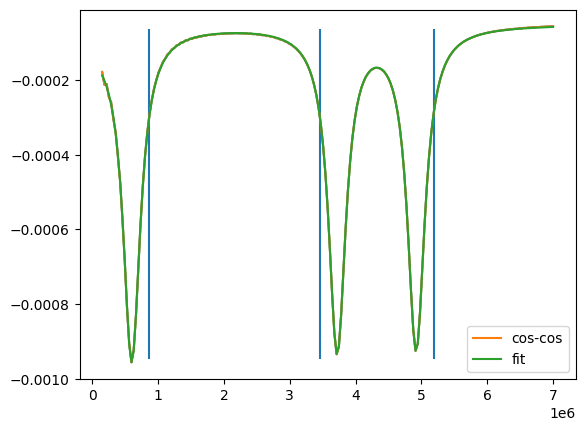

In [884]:
orientation = 2
inner_product_settings = InnerProductSettings(MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, rabi_window="blackman", ramsey_window="boxcar", subtract_mean=True, use_effective_rabi_frequency=True)
ramsey_freq_range_hz = np.linspace(.15e6, 7e6, 201)
cos_cos_inner_prod=double_cosine_inner_product_vs_ramsey(sq_cancelled_signal, rabi_frequencies[orientation], ramsey_freq_range_hz, inner_product_settings)
plt.plot(ramsey_freq_range_hz, cos_cos_inner_prod)

fit_result = fit_constrained_hyperfine_peaks(ramsey_freq_range_hz, cos_cos_inner_prod, T2STAR_S)

plot_fit_vs_inner_product(ramsey_freq_range_hz, cos_cos_inner_prod, fit_result)
print(fit_vs_eigenvalue_error_nT(fit_result, larmor_freqs_hz[orientation]))

In [877]:
fit_result.best_values

{'zero_center': 0,
 'zero_fwhm': np.float64(1350709.3353440005),
 'zero_amplitude': np.float64(-4.091902175457066e-05),
 'offset_value': np.float64(-4.959052449091132e-05),
 'p2_center': np.float64(3720222.1453674836),
 'p2_fwhm': np.float64(319541.268916046),
 'p2_amplitude': np.float64(-0.0008681726237891015),
 'p1_center': np.float64(599777.8546325164),
 'p1_fwhm': np.float64(315371.0369854271),
 'p1_amplitude': np.float64(-0.0008807343804484359),
 'p0_center': np.float64(4919777.854632516),
 'p0_fwhm': np.float64(318994.9215938486),
 'p0_amplitude': np.float64(-0.0008611554337211177)}

In [793]:


hyperfine = 0

#sq_cancelled_signal_target = signal_by_orientation[orientation]
#sq_cancelled_signal_total = np.sum(np.array(signal_by_orientation), axis=0)

ramsey_freqs_fine = np.linspace(0.0, 7e6, 101)
rabi_window =  windows.blackman(len(MW_PULSE_LENGTH_S))
ramsey_window = 1 #np.exp(-EVOLUTION_TIME_S/(2*T2STAR_S))


#optimal_value_cos = minimize(cos_cos_inner_product_to_minimize_rabi_ramsey, [np.abs(2*(gammab*bz_values_nv_coords_t[orientation][hyperfine])),rabi_frequencies[orientation]], ( EVOLUTION_TIME_S, MW_PULSE_LENGTH_S, sq_cancelled_signal_target, rabi_window, ramsey_window, False), method='Nelder-Mead')
#print(optimal_value_cos.x)

double_inner_product_cos_cos = np.array([double_cosine_inner_product2(np.sqrt(rabi_frequencies[orientation]**2 + ramsey_freq_hz**2),ramsey_freq_hz,MW_PULSE_LENGTH_S, EVOLUTION_TIME_S, sq_cancelled_signal, rabi_window=rabi_window, ramsey_window=ramsey_window, mean_subtracted=True) for ramsey_freq_hz in ramsey_freqs_fine])
print(double_inner_product_cos_cos[10])
print(cos_cos_inner_prod[10])

-0.0004837867973456297
-0.00048557550046675503


In [875]:
np.array(bz_values_nv_coords_t)*2*gammab

array([[-2120000.        ,  2200000.        ,  6520000.        ],
       [-5053333.33333333,  -733333.33333333,  3586666.66666667],
       [-4920000.        ,  -600000.        ,  3720000.        ],
       [-5186666.66666667,  -866666.66666667,  3453333.33333333]])

In [885]:
from pathlib import Path

In [886]:
print(Path.cwd())

/Users/lilianchildress/Documents/GitHub/sbq-dq-simulator/bff_paper_figures
